# Identification of corn leaf diseases using machine learning technology


### Deskripsi

Proyek ini bertujuan untuk mengembangkan sistem deteksi penyakit tanaman jagung secara otomatis menggunakan teknologi machine learning, khususnya dengan dua algoritma yang umum digunakan: **Convolutional Neural Network (CNN)** dan **Model Transfer Learning DenseNet121**. Dengan sistem ini, diharapkan petani dapat mendeteksi penyakit pada daun jagung secara cepat dan akurat, meningkatkan efisiensi diagnosis penyakit di lapangan.

### Tujuan Penelitian

Penelitian ini bertujuan untuk:
1. Mengembangkan metode deteksi penyakit tanaman jagung melalui citra daun.
2. Menguji dan membandingkan akurasi antara model CNN dan Transfer Learning DenseNet121.
3. Mengimplementasikan model dengan akurasi tertinggi untuk deteksi penyakit berbasis citra.

### Dataset

Dataset untuk proyek ini diperoleh melalui survei langsung di ladang jagung masyarakat, dengan total:
- 5368 gambar daun jagung.
- 10 video daun jagung.

Data tersebut diklasifikasikan ke dalam 4 kelas: **Hawar**, **Bercak Daun**, **Karat**, dan **Sehat**.

## Table of Contents
* [Import Libraries and Modules](#ImportLibrariesandModules)
* [Preprocessing dan Augmentasi Gambar](#PreprocessingdanAugmentasiGambar)
* [Visualisasi Data Gambar](#VisualisasiDataGambar)
* [Penerapan Canny Edge Detection](#PenerapanCannyEdgeDetection)
* [Pengembangan Model](#PengembanganModelCNN)
* [Menyimpan Model](#MenyimpanModeL)
* [Melatih Model](#MelatihModelCNN)
* [Evaluasi Model](#EvaluasiModel)
* [Performance](#Performance)
* [Prediction](#Prediction)

<a name="ImportLibrariesandModules"></a>

# Import Libraries and Modules

In [19]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


<a name="PreprocessingdanAugmentasiGambar"></a>

# Preprocessing dan Augmentasi Gambar dengan Roboflow

Dalam proyek ini, kami menggunakan Roboflow untuk melakukan preprocessing dan augmentasi gambar secara otomatis. Berikut adalah langkah-langkah yang diterapkan untuk mempersiapkan gambar sebelum digunakan dalam pelatihan model.

## Preprocessing

Preprocessing adalah tahap penting yang dilakukan untuk memastikan gambar berada dalam format dan ukuran yang sesuai dengan kebutuhan model. Berikut adalah beberapa teknik preprocessing yang diterapkan:

1. **Auto-Orient:** Menyesuaikan orientasi gambar untuk memastikan gambar dalam posisi yang benar dan tidak terbalik.
2. **Static Crop:** Gambar dipotong pada area tertentu untuk memperkecil fokus:
   - **Horizontal Region:** Pemotongan dilakukan pada **25%-75%** bagian horizontal gambar.
   - **Vertical Region:** Pemotongan dilakukan pada **27%-75%** bagian vertikal gambar.
3. **Resize:** Gambar akan diubah ukurannya menjadi **640x640** piksel untuk memastikan ukuran input yang konsisten pada model.

## Augmentasi

Untuk memperkaya dataset dan meningkatkan akurasi model, augmentasi gambar digunakan. Dengan Roboflow, kami dapat melakukan berbagai augmentasi secara otomatis, seperti:

1. **Outputs per Training Example:** Untuk setiap gambar dalam dataset, Roboflow menghasilkan **3 output gambar** yang berbeda untuk meningkatkan variasi dalam data pelatihan.
2. **Flip Horizontal:** Melakukan flip gambar secara horizontal (spion kiri-kanan) untuk menciptakan variasi dalam orientasi objek.
3. **Grayscale:** 15% dari gambar diterapkan dengan filter grayscale untuk menambah variasi dalam warna gambar.
4. **Hue:** Perubahan hue gambar dilakukan dalam rentang **-25° hingga +25°** untuk variasi warna.
5. **Saturation:** Saturasi gambar disesuaikan antara **-25% hingga +25%** untuk variasi kecerahan warna.
6. **Brightness:** Kecerahan gambar diubah dalam rentang **-25% hingga +25%**.
7. **Exposure:** Exposure gambar disesuaikan antara **-12% hingga +12%** untuk perubahan kontras.
8. **Crop:** Gambar akan dipotong secara acak untuk meningkatkan variasi objek yang terlihat dalam gambar.
9. **90 Derajat Rotation:** Gambar akan diputar 90 derajat untuk meningkatkan variasi sudut pandang gambar.
10. **Histogram Equalization dan Median Filtering:** Digunakan untuk meningkatkan kualitas visual gambar.

Dengan menggunakan Roboflow, semua augmentasi ini diterapkan secara otomatis dan sangat membantu dalam memperkaya dataset dan mencegah overfitting selama pelatihan model


In [2]:
data_path = r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder"

train_path = os.path.join(data_path, "train")
valid_path = os.path.join(data_path, "valid")
test_path = os.path.join(data_path, "test")

# Hyperparameter
batch_size = 32
img_size = (256, 256)

# Data augmentation untuk training
tr_gen = ImageDataGenerator(rescale=1./255)

# Hanya rescaling untuk validasi dan testing
ts_gen = ImageDataGenerator(rescale=1./255)

# Load data dari folder
train_gen = tr_gen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_gen = ts_gen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = ts_gen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Memastikan dataset terdeteksi dengan benar
print("Train Classes:", train_gen.class_indices)


Found 4392 images belonging to 4 classes.
Found 488 images belonging to 4 classes.
Found 488 images belonging to 4 classes.
Train Classes: {'Bercak': 0, 'Hawar': 1, 'Karat': 2, 'Sehat': 3}


<a name="VisualisasiDataGambar"></a>

# Visualisasi Data Gambar
Pada tahap ini, kami memvisualisasikan beberapa gambar dari dataset untuk mendapatkan gambaran yang lebih baik mengenai kelas-kelas yang ada dalam dataset.

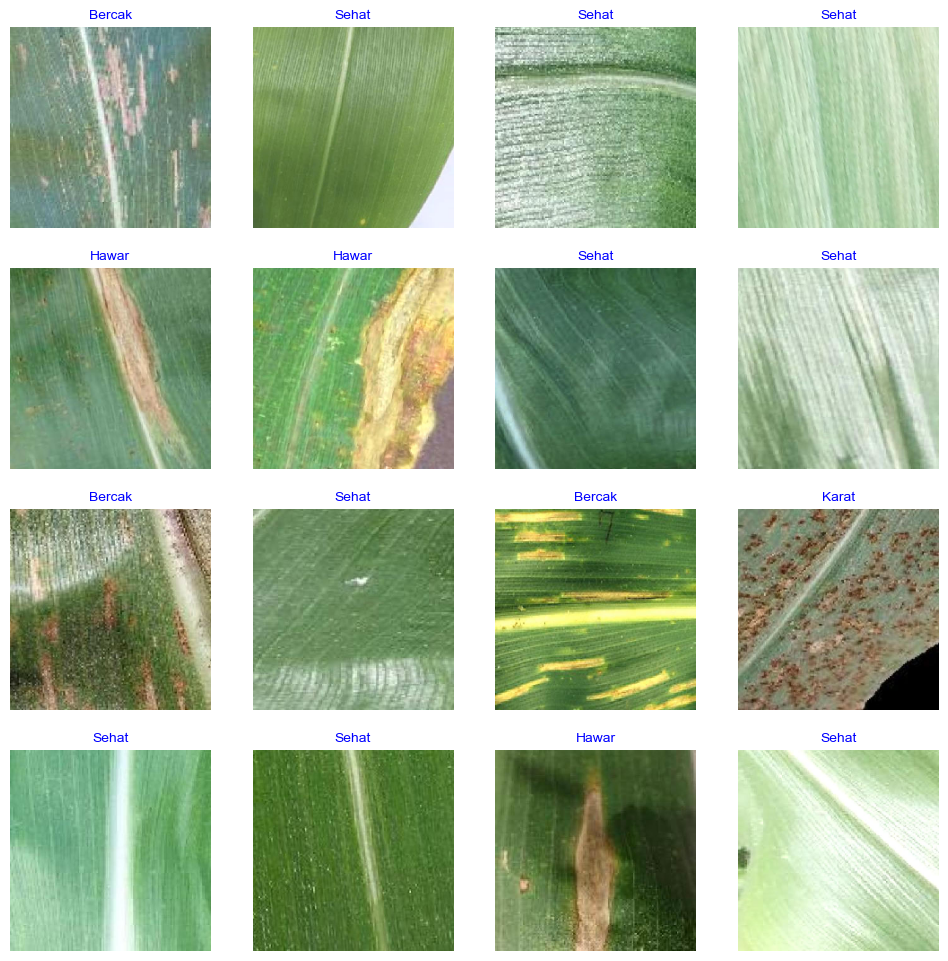

In [21]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize=(12, 12))

for i in range(16):  # Menampilkan 16 gambar dari batch pertama
    plt.subplot(4, 4, i + 1)
    image = images[i]  # Gambar
    label_index = np.argmax(labels[i])  # Label
    class_name = classes[label_index]  # Nama kelas
    plt.imshow(image)
    plt.title(class_name, color='blue', fontsize=10)
    plt.axis('off')

plt.show()


<a name="PenerapanCannyEdgeDetection"></a>

# Penerapan Canny Edge Detection
Teknik deteksi tepi menggunakan Canny digunakan untuk memvisualisasikan detail dan fitur-fitur penting pada gambar daun jagung. Ini dapat membantu model untuk memfokuskan pada fitur yang relevan selama pelatihan.

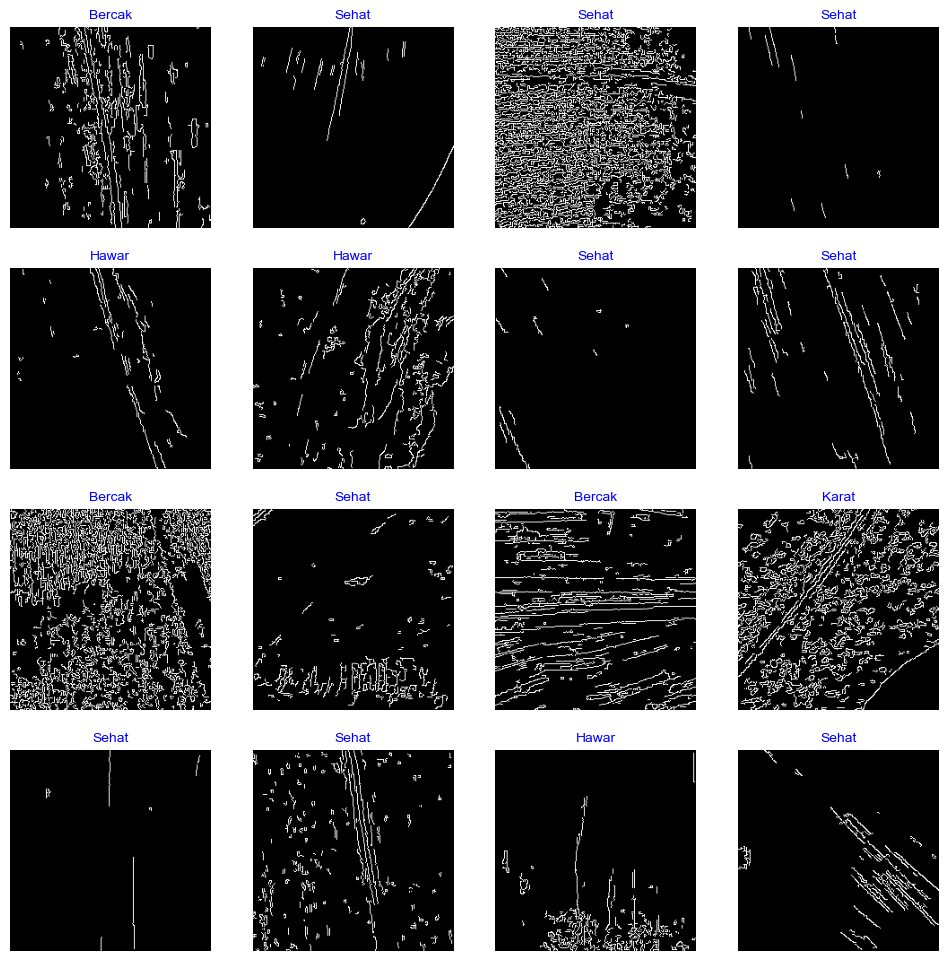

In [22]:
def apply_canny_edge_detection(image):
    if len(image.shape) == 3:  # Jika gambar RGB, ubah ke grayscale
        gray_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        gray_image = (image * 255).astype(np.uint8)
    
    edges = cv2.Canny(gray_image, 100, 200)  # Deteksi tepi
    return edges

plt.figure(figsize=(12, 12))

for i in range(16):  # Menampilkan 16 gambar
    plt.subplot(4, 4, i + 1)
    edges = apply_canny_edge_detection(images[i])  # Deteksi tepi
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  # Ubah ke RGB untuk plt
    class_name = classes[np.argmax(labels[i])]  # Nama kelas
    plt.imshow(edges_rgb)
    plt.title(class_name, color='blue', fontsize=10)
    plt.axis('off')

plt.show()


<a name="PenerapanCannyEdgeDetection"></a>

# Histogram Equalization dan Median Filtering
peningkatan dalam kualitas visual gambar yang digunakan untuk pelatihan model

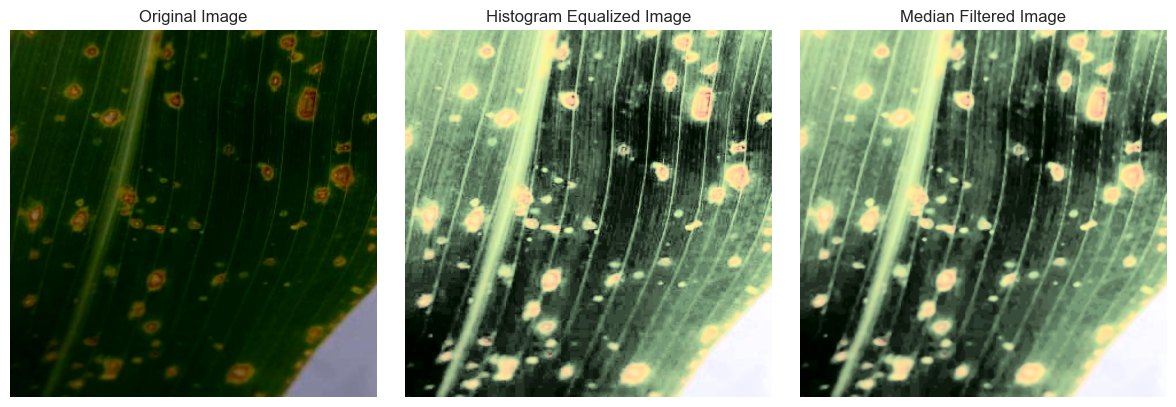

In [31]:
import cv2
import matplotlib.pyplot as plt

# Membaca gambar berwarna
image = cv2.imread(r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\train\Bercak\CamScanner-04-11-2024-20-52_10_jpg.rf.049eae9ba61c81e67be7f72582c2f8cf.jpg")

# Mengkonversi gambar dari RGB ke LAB
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Pisahkan channel L, a, b
l, a, b = cv2.split(image_lab)

# Equalisasi histogram pada channel L (luminositas)
l_equalized = cv2.equalizeHist(l)

# Gabungkan kembali channel L yang sudah di-equalize dengan channel a dan b yang asli
image_lab_equalized = cv2.merge([l_equalized, a, b])

# Konversi gambar kembali ke RGB
image_equalized = cv2.cvtColor(image_lab_equalized, cv2.COLOR_LAB2BGR)

# Penyaringan Median
median_filtered_image = cv2.medianBlur(image_equalized, 5)  # Ukuran kernel 5x5 untuk median filter

# Menampilkan gambar asli, hasil equalization, dan hasil filtering
plt.figure(figsize=(12, 4))

# Gambar asli
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Gambar setelah Histogram Equalization
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image_equalized, cv2.COLOR_BGR2RGB))
plt.title('Histogram Equalized Image')
plt.axis('off')

# Gambar setelah Median Filtering
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(median_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Median Filtered Image')
plt.axis('off')

# Menata layout gambar
plt.tight_layout()
plt.show()


<a name="PengembanganModelCNN"></a>

# Pengembangan Model CNN
Di sini, kita mendefinisikan struktur dari Convolutional Neural Network (CNN). Model ini terdiri dari beberapa lapisan konvolusional, lapisan max-pooling, dan lapisan dropout untuk mengurangi overfitting. Lapisan terakhir adalah lapisan dense dengan fungsi aktivasi softmax, yang cocok untuk klasifikasi multi-kelas.

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Definisi model CNN
model = Sequential() # Model dibangun dengan arsitektur Sequential, artinya lapisan-lapisan akan ditambahkan secara berurutan.

model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')) # activation='relu': Fungsi aktivasi Rectified Linear Unit
model.add(BatchNormalization()) # Menormalkan aktivasi untuk mempercepat pelatihan dan stabilitas.
model.add(MaxPooling2D(pool_size=(2, 2))) # Mengambil maksimum dalam wilayah 2x2.

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# GlobalAveragePooling menggantikan Flatten
model.add(tf.keras.layers.GlobalAveragePooling2D()) # Global Average Pooling menggantikan Flatten untuk merangkum informasi fitur dengan rata-rata. Ini mengurangi dimensi secara signifikan, sehingga mengurangi overfitting.
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dense(4, activation='softmax')) # softmax: Menghasilkan probabilitas untuk setiap kelas.

# Menampilkan ringkasan model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 588,100 (2.24 MB)

 Trainable params: 587,140 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

<a name="PengembanganModelCNN"></a>

# Diagram Arsitektur Model CNN dengan Layer Detail dan Dimensi

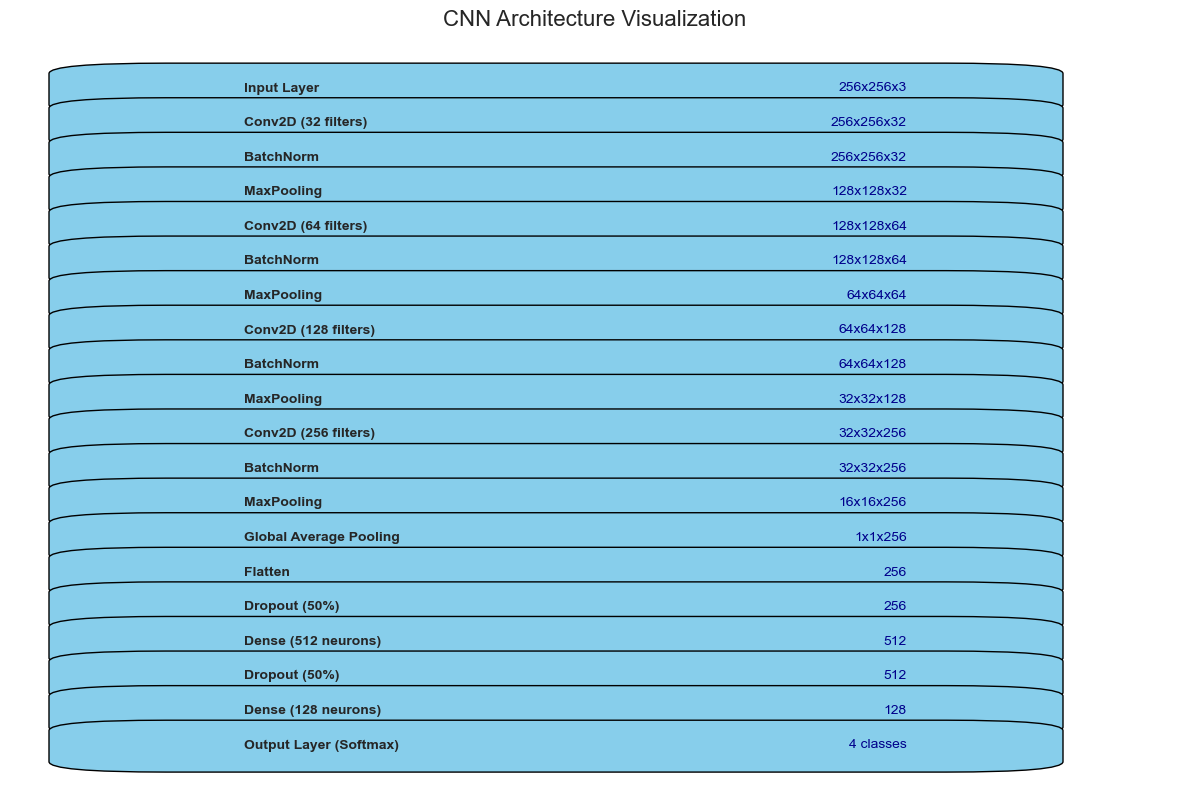

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Data dari model summary
layers = [
    ("Input Layer", "256x256x3"),
    ("Conv2D (32 filters)", "256x256x32"),
    ("BatchNorm", "256x256x32"),
    ("MaxPooling", "128x128x32"),
    ("Conv2D (64 filters)", "128x128x64"),
    ("BatchNorm", "128x128x64"),
    ("MaxPooling", "64x64x64"),
    ("Conv2D (128 filters)", "64x64x128"),
    ("BatchNorm", "64x64x128"),
    ("MaxPooling", "32x32x128"),
    ("Conv2D (256 filters)", "32x32x256"),
    ("BatchNorm", "32x32x256"),
    ("MaxPooling", "16x16x256"),
    ("Global Average Pooling", "1x1x256"),
    ("Flatten", "256"),
    ("Dropout (50%)", "256"),
    ("Dense (512 neurons)", "512"),
    ("Dropout (50%)", "512"),
    ("Dense (128 neurons)", "128"),
    ("Output Layer (Softmax)", "4 classes")
]

# Membuat visualisasi diagram blok
fig, ax = plt.subplots(figsize=(12, 8))

# Posisi Y untuk setiap lapisan
y_positions = list(range(len(layers), 0, -1))

# Plot blok
for i, (layer_name, output_shape) in enumerate(layers):
    y = y_positions[i]
    ax.add_patch(FancyBboxPatch(
        (-0.1, y - 0.5), 2, 0.9,  # Posisi dan ukuran blok
        boxstyle="round,pad=0.3", ec="black", fc="skyblue"
    ))
    ax.text(0.1, y, layer_name, va="center", ha="left", fontsize=10, weight='bold')
    ax.text(1.8, y, output_shape, va="center", ha="right", fontsize=10, color="darkblue")

# Menambahkan keterangan
ax.set_title("CNN Architecture Visualization", fontsize=16, pad=20)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, len(layers) + 1)
ax.axis("off")

# Menampilkan diagram
plt.tight_layout()
plt.show()


<a name="MenyimpanModel"></a>

# Menyimpan Model 
Model yang telah dilatih disimpan dalam format HDF5 untuk memungkinkan pemuatan dan pengujian model di lain waktu.

In [7]:
model.save('model2.h5')

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
checkpoint = ModelCheckpoint(
    filepath='Model/Model_CNN_256px.keras',  # Pastikan path valid
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


<a name="MelatihModelCNN"></a>

Model yang dilatih sudah disimpan, sehingga tidak perlu melakukan pelatihan data lagi, anda dapat mencoba memakai model berikut :
- Model_CNN_256px.keras
- Model_CNN_128px.keras
- Model_denseNet121_256px.keras
- Model_denseNet121_128px.keras

# Melatih Model CNN
Model ini dilatih dengan menggunakan data pelatihan dan dievaluasi dengan data validasi. Callback seperti `early_stopping` dan `checkpoint` diterapkan untuk mencegah overfitting dan menyimpan model terbaik.

In [9]:
history = model.fit(
    train_gen,  # Generator training
    epochs=30,  # Jumlah epoch
    validation_data=valid_gen,  # Generator validasi
    callbacks=[early_stopping, checkpoint],  # Early stopping & checkpoint
    steps_per_epoch=len(train_gen),  # Langkah per epoch
    validation_steps=len(valid_gen)  # Langkah validasi
)

Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5201 - loss: 1.2466
Epoch 1: val_accuracy improved from -inf to 0.38320, saving model to model/model2.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.5205 - loss: 1.2454 - val_accuracy: 0.3832 - val_loss: 2.3537
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6516 - loss: 0.9165
Epoch 3: val_accuracy did not improve from 0.38320
138/138 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.6517 - loss: 0.9161 - val_accuracy: 0.2869 - val_loss: 3.8692
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7527 - loss: 0.6860
Epoch 5: val_accuracy did not improve from 0.38320
138/138 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.7528 - loss: 0.6859 - val_accuracy: 0.3709 - val_loss: 3.4689
Epoch 6/3

<a name="EvaluasiModel"></a>

# Hyperparameter Tuning
Hyperparameter tuning proses untuk menemukan kombinasi terbaik dari hyperparameter model machine learning, seperti jumlah lapisan, ukuran filter, nilai dropout, dan learning rate, agar model dapat mencapai performa terbaik. Berbeda dengan parameter yang dipelajari selama proses training (seperti weights), hyperparameter ini harus diatur sebelum model dilatih.

Tujuan:

- Meningkatkan akurasi dan performa model di dataset validasi atau testing.

- Menghindari overfitting atau underfitting dengan menemukan keseimbangan konfigurasi model.

- Mengotomatiskan eksperimen untuk mencari parameter yang paling efektif dalam waktu yang lebih singkat.

Instal KerasTuner

In [30]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


Definisikan Fungsi Build Model untuk KerasTuner

In [12]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 3)))
    
    # Hyperparameter: jumlah filter
    for i in range(hp.Int('conv_layers', 2, 4)):  # 2-4 lapisan konvolusi
        model.add(
            Conv2D(
                filters=hp.Choice(f'filters_{i}', [32, 64, 128, 256]),
                kernel_size=(3, 3),
                padding='same',
                activation='relu'
            )
        )
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [0.001, 0.0001, 0.00001])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Tuning dengan KerasTuner

In [32]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='cnn_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=[stop_early]
)

# Menampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Jumlah lapisan konvolusi terbaik: {best_hps.get('conv_layers')}
Dropout terbaik: {best_hps.get('dropout')}
Learning rate terbaik: {best_hps.get('learning_rate')}
""")


Trial 20 Complete [00h 45m 15s]
val_accuracy: 0.9508196711540222

Best val_accuracy So Far: 0.9692623019218445
Total elapsed time: 14h 51m 53s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
4                 |3                 |conv_layers
32                |64                |filters_0
256               |256               |filters_1
0.6               |0.3               |dropout
0.0001            |0.0001            |learning_rate
128               |128               |filters_2
32                |128               |filters_3
7                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/7
 52/138 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.4377 - loss: 1.2685

KeyboardInterrupt: 

In [33]:
# Ambil hasil hyperparameter terbaik sejauh ini
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter terbaik sejauh ini:
- Jumlah lapisan konvolusi: {best_hps.get('conv_layers')}
- Dropout terbaik: {best_hps.get('dropout')}
- Learning rate terbaik: {best_hps.get('learning_rate')}
""")



Hyperparameter terbaik sejauh ini:
- Jumlah lapisan konvolusi: 3
- Dropout terbaik: 0.3
- Learning rate terbaik: 0.0001



In [34]:
model.save('best_model.h5')


In [35]:
# Plot hasil tuning
tuner.results_summary()


Results summary
Results in hyperparameter_tuning\cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
conv_layers: 3
filters_0: 64
filters_1: 256
dropout: 0.3
learning_rate: 0.0001
filters_2: 128
filters_3: 128
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.9692623019218445

Trial 0017 summary
Hyperparameters:
conv_layers: 4
filters_0: 128
filters_1: 32
dropout: 0.3
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
filters_2: 32
filters_3: 32
tuner/trial_id: 0014
Score: 0.9692623019218445

Trial 0019 summary
Hyperparameters:
conv_layers: 4
filters_0: 32
filters_1: 128
dropout: 0.4
learning_rate: 0.0001
filters_2: 256
filters_3: 64
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9508196711540222

Trial 0015 summary
Hyperparameters:
conv_layers: 3
filters_0: 64
filters_1: 256
dropout: 0.3
learni

# Hyperparameter Tuning Grid Search

###  Import Library dan Muat Model

In [34]:
from tensorflow.keras.models import load_model
import os
import json
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pretrained model
base_model_path = 'Model/Model_CNN_256px.keras'
pretrained_model = load_model(base_model_path)
pretrained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,762,382 (6.72 MB)

 Trainable params: 587,140 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,174,282 (4.48 MB)

### Dataset Preparation

In [3]:
# Dataset preparation
train_data = tf.keras.utils.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))

val_data = tf.keras.utils.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\valid',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))

# Data augmentation
datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=30,
    rescale=1.0 / 255)

train_data_augmented = datagen.flow_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)


Found 4392 files belonging to 4 classes.
Found 488 files belonging to 4 classes.
Found 4392 images belonging to 4 classes.


### Arsitektur Model CNN

In [35]:
# Define CNN model architecture
def build_cnn_model():
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 3)))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model.add(Dense(4, activation='softmax'))
    
    return model


### Grid Search Parameters

In [6]:
# Grid Search parameters
param_grid = {
    'learning_rate': [0.001, 0.0005],
    'optimizer': ['adam', 'adamax'],
}

# Create folder to save results
os.makedirs('GridSearch_Results', exist_ok=True)

### Inisialisasi Variabel

In [7]:
# Initialize tracking variables
best_val_accuracy = 0
best_params = None
trial_results = []

trial_number = 1

### Fungsi Optimizer

In [8]:
# Define optimizer helper function
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif name == 'adamax':
        return Adamax(learning_rate=learning_rate)
    elif name == 'sgd':
        return SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unknown optimizer")


###  Implementasi Grid Search

In [10]:
# Memuat model yang sudah ada
model = load_model('Model/Model_CNN_256px.keras')

# Mulai Grid Search
for learning_rate in param_grid['learning_rate']:
    for optimizer_name in param_grid['optimizer']:
        if trial_number > 4:
            break  # Batalkan jika sudah mencapai jumlah percobaan yang diinginkan

        print(f"\n[Trial {trial_number}] Tuning dengan learning_rate={learning_rate}, optimizer={optimizer_name}")

        # Pilih optimizer
        optimizer = get_optimizer(optimizer_name, learning_rate)

        # Kompilasi model dengan optimizer yang berbeda
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Evaluasi model
        evaluation = model.evaluate(val_data)
        val_loss, val_accuracy = evaluation[0], evaluation[1]

        print(f"\n[Trial {trial_number} Results] Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}\n")

        # Simpan hasil percobaan
        trial_result = {
            'trial_number': trial_number,
            'parameters': {
                'learning_rate': learning_rate,
                'optimizer': optimizer_name
            },
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        }
        trial_results.append(trial_result)

        result_file = os.path.join('GridSearch_Results', f'Trial_{trial_number}_Results.json')
        with open(result_file, 'w') as f:
            json.dump(trial_result, f, indent=4)

        # Update hasil terbaik
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = trial_result['parameters']
            best_file = os.path.join('GridSearch_Results', 'Best_Trial_Results.json')
            with open(best_file, 'w') as f:
                json.dump(trial_result, f, indent=4)

        trial_number += 1



[Trial 1] Tuning dengan learning_rate=0.001, optimizer=adam
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.9610 - loss: 0.1584

[Trial 1 Results] Validation Loss: 0.15948058664798737, Validation Accuracy: 0.9549180269241333


[Trial 2] Tuning dengan learning_rate=0.001, optimizer=adamax
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.9610 - loss: 0.1529

[Trial 2 Results] Validation Loss: 0.15948055684566498, Validation Accuracy: 0.9549180269241333


[Trial 3] Tuning dengan learning_rate=0.0005, optimizer=adam
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy: 0.9647 - loss: 0.1421

[Trial 3 Results] Validation Loss: 0.15948055684566498, Validation Accuracy: 0.9549180269241333


[Trial 4] Tuning dengan learning_rate=0.0005, optimizer=adamax
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.9570 - loss: 0.1707

[Trial 4 Results] Validation Loss: 0.15948055684566498, Validation Accuracy: 0.9549180269241333



In [11]:
# Menampilkan hasil akhir
print("\nGrid Search Selesai!\n")
print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Parameters: {best_params}")



Grid Search Selesai!

Best Validation Accuracy: 0.9549180269241333
Best Parameters: {'learning_rate': 0.001, 'optimizer': 'adam'}


In [12]:
# Menyimpan hasil terbaik setelah grid search selesai
with open('GridSearch_Results/Best_Trial_Results.json', 'w') as f:
    json.dump({
        'best_val_accuracy': best_val_accuracy,
        'best_params': best_params
    }, f, indent=4)


# Hyperparameter Tuning Hyperband

In [15]:
import os
import json
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam, Adamax, SGD

In [16]:
# Dataset preparation
train_data = tf.keras.utils.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))

val_data = tf.keras.utils.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\valid',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))

Found 4392 files belonging to 4 classes.


Found 488 files belonging to 4 classes.


### Menggunakan Model yang Sudah Dilatih (base_model_path)

In [17]:
# Load pretrained model
base_model_path = 'Model/Model_CNN_256px.keras'
pretrained_model = load_model(base_model_path)
pretrained_model.summary()

# Freeze base model layers
pretrained_model.trainable = False  # Freeze the convolutional base layers


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,762,382 (6.72 MB)

 Trainable params: 587,140 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,174,282 (4.48 MB)

### Membangun Model dengan Hyperband

In [18]:
# Define model builder for Hyperband
def build_model(hp):
    model = Sequential()
    model.add(pretrained_model)  # Add the pretrained base model
    model.add(BatchNormalization())
    
    # Adding dense layers with hyperparameters
    model.add(Dense(hp.Choice('dense_units', [128, 256, 512]), activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(Dropout(hp.Choice('dropout_rate', [0.3, 0.4, 0.5])))
    model.add(BatchNormalization())
    model.add(Dense(128, activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(Dense(4, activation='softmax'))  # 4 classes for classification

    # Compile model with hyperparameter choice
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'adamax', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


### Inisialisasi dan Menjalankan Hyperband Tuning

In [19]:
# Create Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='Hyperband_Results',
    project_name='Cornleaf_Disease_Classification'
)


### Melakukan Tuning Hyperparameter dan Menyimpan Model Terbaik

In [20]:
from keras.callbacks import EarlyStopping
import os
import json

# Perform Hyperparameter Tuning
def train_and_save_best_model():
    # Early stopping callback to avoid overfitting and stop training when no improvement is seen
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Perform Hyperband search with limited epochs for quicker tuning
    tuner.search(train_data_augmented,
                 epochs=5,  # Reduce the number of epochs for faster search
                 validation_data=val_data,
                 verbose=1,
                 callbacks=[early_stopping])  # Use early stopping to prevent overfitting

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]

    print("\nBest Hyperparameters:")
    print(f"Dense Units: {best_hps.get('dense_units')}")
    print(f"Activation: {best_hps.get('activation')}")
    print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
    print(f"Optimizer: {best_hps.get('optimizer')}")

    # Build the best model with selected hyperparameters
    best_model = tuner.hypermodel.build(best_hps)

    # Train the best model with reduced epochs but using early stopping
    history = best_model.fit(train_data_augmented,
                              epochs=10,  # Keep the final training epochs reasonable
                              validation_data=val_data,
                              verbose=1,
                              callbacks=[early_stopping])  # Apply early stopping to this as well

    # Save the best model
    os.makedirs('Hyperband_Results/Best_Model', exist_ok=True)
    best_model.save('Hyperband_Results/Best_Model/best_model.h5')

    # Save training history
    with open('Hyperband_Results/Best_Model/history.json', 'w') as f:
        json.dump(history.history, f, indent=4)

    return best_model

# Run training and save best model
best_model = train_and_save_best_model()

print("\nHyperband Tuning Complete! Best model saved.")


Trial 29 Complete [00h 17m 58s]
val_accuracy: 0.9651639461517334

Best val_accuracy So Far: 0.9774590134620667
Total elapsed time: 03h 22m 30s

Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
128               |128               |dense_units
relu              |relu              |activation
0.4               |0.4               |dropout_rate
sgd               |adam              |optimizer
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 112s 798ms/step - accuracy: 0.7201 - loss: 0.7493 - val_accuracy: 0.9611 - val_loss: 0.7324
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 114s 823ms/step - accuracy: 0.8923 - loss: 0.3833 - val_accuracy: 0.9631 - val_loss: 0.2980
Epoch 3/10
 61/138 ━━━━━━━━━━━━━━━━━━━━ 1:02 818ms/step - accuracy: 0.8924 - loss: 0.3975

KeyboardInterrupt: 

### Menampilkan Semua Hasil Trial dari Hyperband

In [21]:
import os

# Path to the Hyperband results directory
project_dir = os.path.join('Hyperband_Results', 'Cornleaf_Disease_Classification')

# Display all trials results
print("=== All Trial Results ===")
for trial_id, trial in tuner.oracle.trials.items():
    print(f"Trial ID: {trial_id}")
    print("Hyperparameters:")
    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")
    
    # Display objective value (e.g., val_accuracy)
    print(f"Objective Value (val_accuracy): {trial.score}")
    
    # Status of the trial (COMPLETED, RUNNING, or INVALID)
    print(f"Status: {trial.status}")
    
    # Path to model for this trial (if saved)
    trial_model_path = os.path.join(project_dir, trial_id, 'model_trial.h5')
    if os.path.exists(trial_model_path):
        print(f"Model Path: {trial_model_path}")
    else:
        print("Model Path: Not saved.")
    print("-" * 50)


=== All Trial Results ===
Trial ID: 0000
Hyperparameters:
  dense_units: 256
  activation: tanh
  dropout_rate: 0.5
  optimizer: adamax
  tuner/epochs: 2
  tuner/initial_epoch: 0
  tuner/bracket: 2
  tuner/round: 0
Objective Value (val_accuracy): 0.9651639461517334
Status: COMPLETED
Model Path: Not saved.
--------------------------------------------------
Trial ID: 0001
Hyperparameters:
  dense_units: 512
  activation: tanh
  dropout_rate: 0.5
  optimizer: adam
  tuner/epochs: 2
  tuner/initial_epoch: 0
  tuner/bracket: 2
  tuner/round: 0
Objective Value (val_accuracy): 0.9733606576919556
Status: COMPLETED
Model Path: Not saved.
--------------------------------------------------
Trial ID: 0002
Hyperparameters:
  dense_units: 256
  activation: tanh
  dropout_rate: 0.3
  optimizer: sgd
  tuner/epochs: 2
  tuner/initial_epoch: 0
  tuner/bracket: 2
  tuner/round: 0
Objective Value (val_accuracy): 0.9610655903816223
Status: COMPLETED
Model Path: Not saved.
----------------------------------

# Hyperparameter Tuning Random Search

In [43]:
import os
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.callbacks import EarlyStopping
import random


In [45]:
# Dataset preparation
train_data = tf.keras.utils.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))

val_data = tf.keras.utils.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\valid',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))

Found 4392 files belonging to 4 classes.
Found 488 files belonging to 4 classes.


### Define CNN Model Function

In [46]:
def build_cnn_model(activation, dropout_rate):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 3)))

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation=activation, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation=activation, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=activation, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation=activation, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation))
    model.add(Dense(4, activation='softmax'))

    return model


### Load Pretrained Model

In [24]:
# Load pretrained model
base_model_path = 'Model/Model_CNN_256px.keras'
pretrained_model = load_model(base_model_path)
pretrained_model.summary()

# Freeze base model layers
pretrained_model.trainable = False

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,762,382 (6.72 MB)

 Trainable params: 587,140 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,174,282 (4.48 MB)

### Define Optimizer Helper Function

In [47]:
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif name == 'adamax':
        return Adamax(learning_rate=learning_rate)
    elif name == 'sgd':
        return SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unknown optimizer")


### Folder untuk Menyimpan Hasil

In [27]:
# Create folder to save results
os.makedirs('RandomSearch_Results', exist_ok=True)

### Set Random Search Parameters

In [48]:
param_space = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'optimizer': ['adam', 'adamax', 'sgd'],
    'dropout_rate': [0.3, 0.4, 0.5],
    'activation': ['relu', 'tanh']
}

os.makedirs('RandomSearch_Results', exist_ok=True)


### Perform Random Search

In [50]:
import os
import random
import json

# Inisialisasi variabel untuk random search
best_val_accuracy = 0
best_params = None
trial_results = []
num_trials = 5

# Direktori hasil
os.makedirs('RandomSearch_Results', exist_ok=True)

for trial_number in range(1, num_trials + 1):
    print(f"\n[Trial {trial_number}] Starting...")

    # Pemilihan parameter secara acak
    learning_rate = random.choice(param_space['learning_rate'])
    optimizer_name = random.choice(param_space['optimizer'])
    dropout_rate = random.choice(param_space['dropout_rate'])
    activation = random.choice(param_space['activation'])

    print(f"Selected Parameters: learning_rate={learning_rate}, optimizer={optimizer_name}, dropout_rate={dropout_rate}, activation={activation}")

    # Membangun dan meng-compile model
    model = build_cnn_model(activation, dropout_rate)
    optimizer = get_optimizer(optimizer_name, learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callback Early Stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

    # Melatih model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=5,  # Mengurangi epoch untuk mempercepat
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluasi model
    val_loss, val_accuracy = model.evaluate(val_data, verbose=0)

    print(f"\n[Trial {trial_number}] Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")

    # Menyimpan hasil percobaan
    trial_result = {
        'trial_number': trial_number,
        'parameters': {
            'learning_rate': learning_rate,
            'optimizer': optimizer_name,
            'dropout_rate': dropout_rate,
            'activation': activation
        },
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }
    trial_results.append(trial_result)

    result_file = os.path.join('RandomSearch_Results', f'Trial_{trial_number}_Results.json')
    with open(result_file, 'w') as f:
        json.dump(trial_result, f, indent=4)

    # Memperbarui trial terbaik
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = trial_result['parameters']
        best_file = os.path.join('RandomSearch_Results', 'Best_Trial_Results.json')
        with open(best_file, 'w') as f:
            json.dump(trial_result, f, indent=4)

# Menampilkan hasil akhir
print("\nRandom Search Complete!\n")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best Parameters: {best_params}")



[Trial 1] Starting...
Selected Parameters: learning_rate=0.0001, optimizer=sgd, dropout_rate=0.5, activation=relu
Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.2583 - loss: 1.9213 - val_accuracy: 0.2459 - val_loss: 1.4007
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.3053 - loss: 1.6414 - val_accuracy: 0.2582 - val_loss: 1.3871
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.3587 - loss: 1.4759 - val_accuracy: 0.4119 - val_loss: 1.2941
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.3835 - loss: 1.4071 - val_accuracy: 0.5410 - val_loss: 1.1231
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.3877 - loss: 1.3892 - val_accuracy: 0.6107 - val_loss: 0.9847
Restoring model weights from the end of the best epoch: 5.

[Trial 1] Validation Loss: 0.9847, Validation Accuracy: 0.6107


[Trial 2] Starting...
Selected Parameters: learning_rate=0.0005, optimizer=adamax, dropout_rate=0.4, activation=relu
Epo

KeyboardInterrupt: 

<a name="EvaluasiModel"></a>

# Visualisasi Hasil Hyperparameter Tuning untuk Model CNN: Hubungan Antara Hyperparameters dan Akurasi Validasi

Dalam eksperimen ini, kami melakukan tuning hyperparameter pada model Convolutional Neural Network (CNN) untuk meningkatkan akurasi pada tugas klasifikasi citra. Hyperparameter yang diuji meliputi jumlah lapisan konvolusi, jumlah filter di setiap lapisan, nilai dropout, dan learning rate. Hasil tuning dibandingkan menggunakan nilai akurasi validasi (val_accuracy) dari setiap percobaan untuk mengevaluasi pengaruh masing-masing hyperparameter terhadap performa model.

### Keterangan
Visualisasi ini menyajikan analisis hasil dari **10 percobaan terbaik dari 20 percobaan** dalam hyperparameter tuning model CNN. Tuning dilakukan dengan berbagai kombinasi hyperparameters untuk menemukan konfigurasi yang menghasilkan akurasi validasi tertinggi. Plot yang disediakan menunjukkan distribusi akurasi berdasarkan jumlah lapisan konvolusi, nilai dropout, dan learning rate, serta identifikasi trial dengan akurasi tertinggi. Hal ini memberikan wawasan mengenai pengaruh masing-masing hyperparameter terhadap performa model CNN.

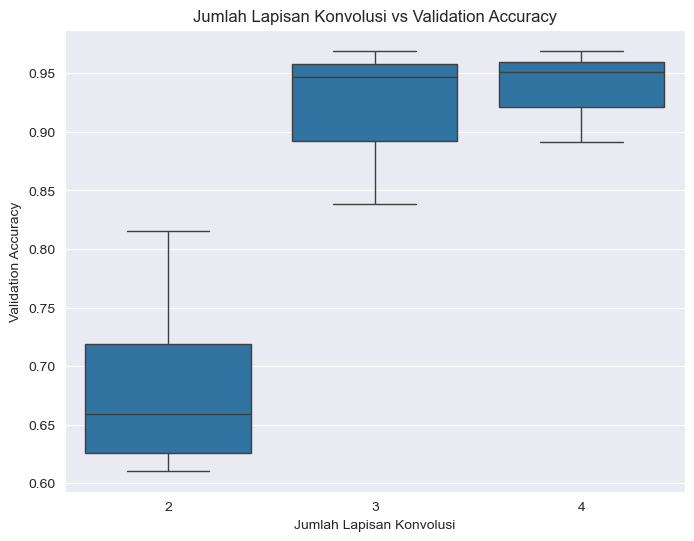

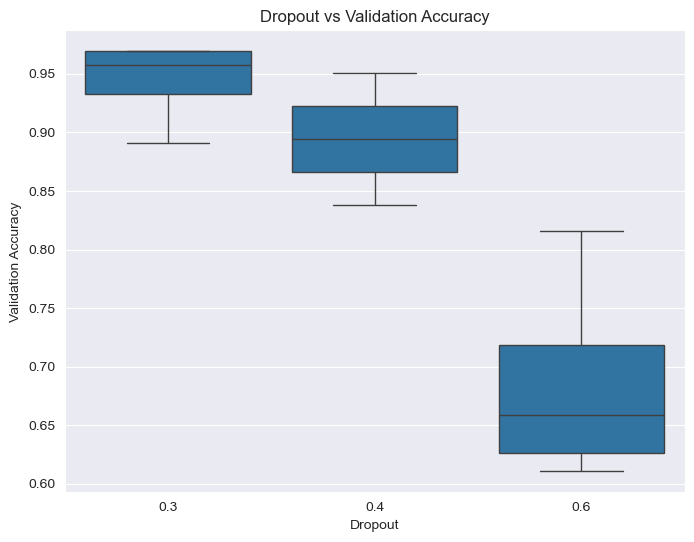

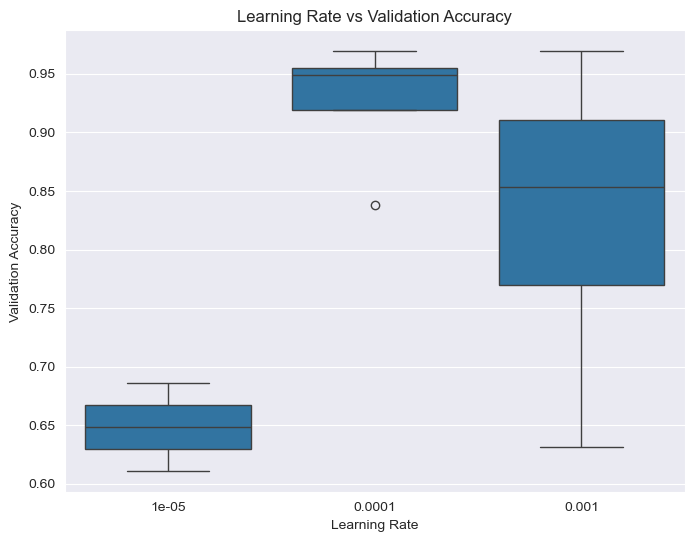

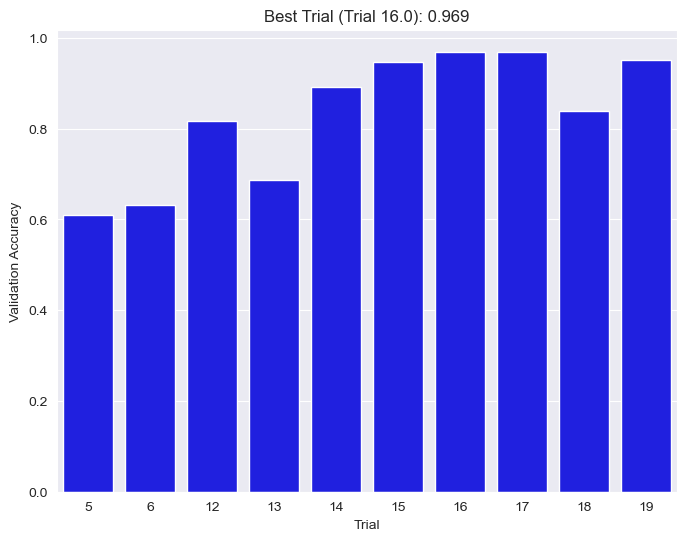

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data hasil hyperparameter tuning
results = {
    "Trial": [16, 17, 19, 15, 14, 18, 12, 13, 6, 5],
    "conv_layers": [3, 4, 4, 3, 4, 3, 2, 2, 2, 2],
    "filters_0": [64, 128, 32, 64, 128, 128, 256, 64, 256, 64],
    "filters_1": [256, 32, 128, 256, 32, 32, 64, 64, 64, 64],
    "filters_2": [128, 32, 256, 128, 32, 128, 128, 256, 128, 256],
    "filters_3": [128, 32, 64, 128, 32, 128, 128, 256, 128, 256],
    "dropout": [0.3, 0.3, 0.4, 0.3, 0.3, 0.4, 0.6, 0.6, 0.6, 0.6],
    "learning_rate": [0.0001, 0.001, 0.0001, 0.0001, 0.001, 0.0001, 0.001, 1e-05, 0.001, 1e-05],
    "val_accuracy": [0.969262, 0.969262, 0.950820, 0.946721, 0.891393, 0.838115, 0.815574, 0.686475, 0.631148, 0.610656]
}

# Konversi ke DataFrame
df = pd.DataFrame(results)

# Plot 1: Jumlah lapisan konvolusi vs val_accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x="conv_layers", y="val_accuracy", data=df)
plt.title("Jumlah Lapisan Konvolusi vs Validation Accuracy")
plt.xlabel("Jumlah Lapisan Konvolusi")
plt.ylabel("Validation Accuracy")
plt.show()

# Plot 2: Dropout vs val_accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x="dropout", y="val_accuracy", data=df)
plt.title("Dropout vs Validation Accuracy")
plt.xlabel("Dropout")
plt.ylabel("Validation Accuracy")
plt.show()

# Plot 3: Learning rate vs val_accuracy
plt.figure(figsize=(8, 6))
sns.boxplot(x="learning_rate", y="val_accuracy", data=df)
plt.title("Learning Rate vs Validation Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.show()

# Plot 4: Visualisasi trial dengan score tertinggi
best_trial = df.loc[df["val_accuracy"].idxmax()]

plt.figure(figsize=(8, 6))
sns.barplot(x="Trial", y="val_accuracy", data=df, color="blue")
plt.title(f"Best Trial (Trial {best_trial['Trial']}): {best_trial['val_accuracy']:.3f}")
plt.xlabel("Trial")
plt.ylabel("Validation Accuracy")
plt.show()


# Evaluasi Model
Model dievaluasi menggunakan data validasi untuk mengukur *loss* dan *accuracy*. Hasil evaluasi ini memberikan gambaran tentang kinerja model pada data yang tidak terlihat sebelumnya.

In [23]:
from tensorflow.keras.models import load_model

# Path model
MODEL_PATH = r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\CornLeaf-Disease-Identification-Using-Machine-Learning\Model\model2.keras"

# Load model
model = load_model(MODEL_PATH)

# Load model yang sudah disimpan
model = load_model("model/model2.keras")

In [24]:
loss, accuracy = model.evaluate(valid_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 450ms/step - accuracy: 0.9622 - loss: 0.1667
Validation Loss: 0.1605
Validation Accuracy: 0.9611


In [25]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - accuracy: 0.9627 - loss: 0.1547
Accuracy score: 0.9610655903816223


### Persiapan Data Uji
Data uji diproses dengan menggunakan `ImageDataGenerator` untuk melakukan rescaling (normalisasi pixel). Generator `test_gen` digunakan untuk memuat gambar dari direktori uji dan mengonversinya ke format yang sesuai dengan model, termasuk mengatur ukuran gambar dan memastikan urutan label tetap konsisten dengan parameter `shuffle=False`.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Direktori dataset uji
test_dir = r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\test"

# Preprocessing dan augmentasi untuk data uji
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generator untuk data uji
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Sesuaikan dengan ukuran input model Anda
    batch_size=32,
    class_mode='categorical',  # Gunakan 'categorical' jika menggunakan lebih dari 2 kelas
    shuffle=False  # Jangan shuffle agar urutan label tetap sama
)

# Menampilkan informasi tentang data uji
print(f"Jumlah gambar uji: {test_gen.samples}")
print(f"Jumlah kelas: {test_gen.num_classes}")

Found 488 images belonging to 4 classes.
Jumlah gambar uji: 488
Jumlah kelas: 4


### Evaluasi Model dengan Data Uji
1. **Persiapan Data Uji**:
   - Data uji diproses dengan `ImageDataGenerator` untuk rescaling gambar.
   - Generator `test_gen` digunakan untuk memuat data uji dan menyiapkannya untuk prediksi.

2. **Evaluasi Model**:
   - Model dievaluasi menggunakan `model.evaluate()`, yang menghasilkan skor akurasi dan loss pada data uji.

3. **Prediksi dan Matriks Evaluasi**:
   - Menggunakan model untuk memprediksi kelas gambar uji.
   - Menghitung **Confusion Matrix** untuk menilai distribusi prediksi.
   - Menampilkan **Classification Report** yang mencakup Precision, Recall, dan F1-Score.
   - Menampilkan hasil precision, recall, dan f1-score secara manual untuk evaluasi lebih lanjut.

4. **Visualisasi**:
   - Menampilkan **Confusion Matrix** menggunakan `seaborn` untuk memvisualisasikan prediksi vs. label sebenarnya.


Found 488 images belonging to 4 classes.


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - accuracy: 0.9642 - loss: 0.1695
Accuracy score: 0.97
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step


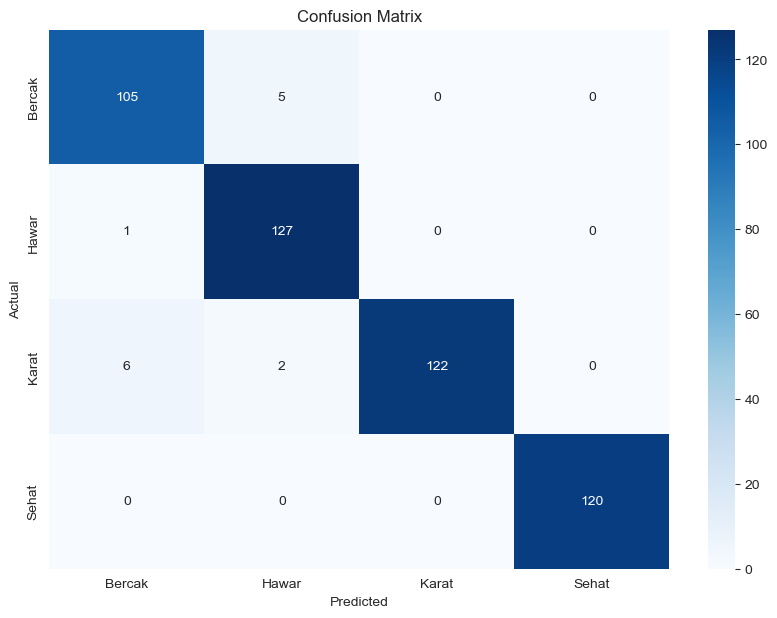

Classification Report:
               precision    recall  f1-score   support

      Bercak       0.94      0.95      0.95       110
       Hawar       0.95      0.99      0.97       128
       Karat       1.00      0.94      0.97       130
       Sehat       1.00      1.00      1.00       120

    accuracy                           0.97       488
   macro avg       0.97      0.97      0.97       488
weighted avg       0.97      0.97      0.97       488

Precision: 0.97
Recall: 0.97
F1-Score: 0.97


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Direktori dataset uji
test_dir = r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\test"

# Preprocessing dan augmentasi untuk data uji
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generator untuk data uji
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Sesuaikan dengan ukuran input model Anda
    batch_size=32,
    class_mode='categorical',  # Gunakan 'categorical' jika menggunakan lebih dari 2 kelas
    shuffle=False  # Jangan shuffle agar urutan label tetap sama
)

# Evaluasi model dengan data uji
loss, accuracy = model.evaluate(test_gen)
print(f"Accuracy score: {accuracy:.2f}")

# Prediksi menggunakan generator data uji
y_true = test_gen.classes  # Kelas asli
y_pred = model.predict(test_gen)  # Prediksi model
y_pred_classes = np.argmax(y_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

    # Classification Report (Precision, Recall, F1-Score)
    report = classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys())
    print("Classification Report:\n", report)

    # Precision
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    print(f"Recall: {recall:.2f}")

    # F1-Score
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    print(f"F1-Score: {f1:.2f}")


<a name="Performance"></a>

# Performance

### Performance: Model Size (Memory Consumption)
1. **Ukuran Model**:
   - Ukuran model dihitung berdasarkan jumlah parameter yang dapat dilatih (trainable parameters) menggunakan `model.count_params()`.
   - Ini memberikan gambaran tentang seberapa besar model dalam hal memori yang diperlukan.

2. **Output**:
   - Hasil dari perintah ini menunjukkan bahwa model memiliki **588,100 parameter**, yang mengindikasikan ukuran model tersebut.
   
3. **Interpretasi**:
   - Semakin besar jumlah parameter, semakin besar memori yang diperlukan untuk menyimpan model, yang menjadi faktor penting ketika model di-deploy pada perangkat dengan keterbatasan sumber daya.

In [22]:
# To check model size
model_size = model.count_params()  # Number of trainable parameters
print(f"Model size (parameters): {model_size}")


Model size (parameters): 588100


### Visualisasi Performa Pelatihan

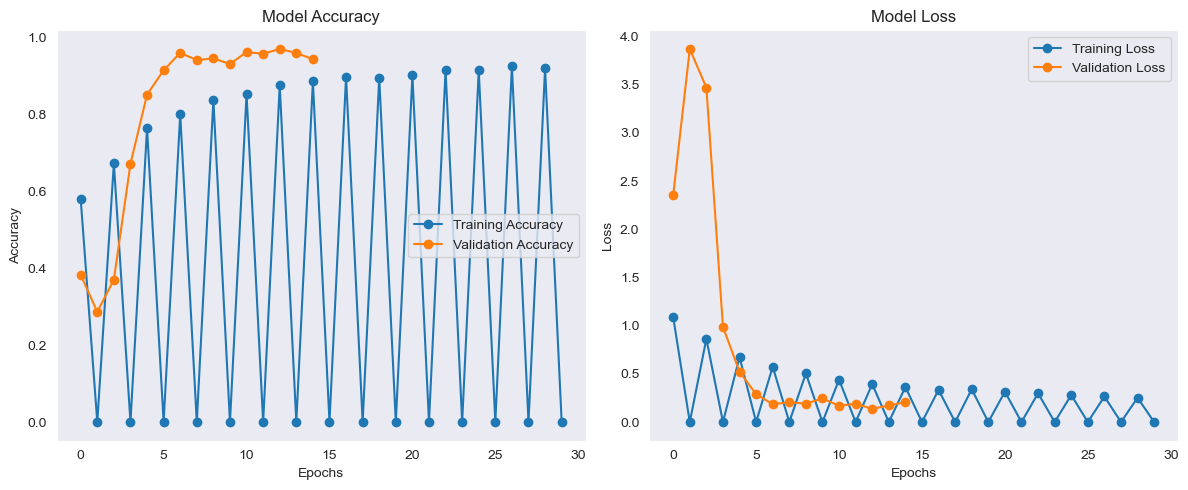

In [11]:
import matplotlib.pyplot as plt

# Mendapatkan data dari history
history_dict = history.history

# Plotting Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### Performance: Evaluasi Overfitting
1. **Plot Loss**:
   - Grafik pertama menunjukkan perbandingan antara **Training Loss** dan **Validation Loss** selama proses pelatihan.
   - Jika model mengalami **overfitting**, kita akan melihat **loss validation** yang lebih tinggi dibandingkan **training loss** di akhir pelatihan.

2. **Plot Akurasi**:
   - Grafik kedua menunjukkan perbandingan antara **Training Accuracy** dan **Validation Accuracy**.
   - Jika model **overfitting**, akurasi pelatihan akan terus meningkat, sementara akurasi validasi bisa stagnan atau menurun.

3. **Interpretasi**:
   - Berdasarkan hasil, jika kedua grafik menunjukkan perilaku yang konsisten antara pelatihan dan validasi tanpa adanya perbedaan signifikan, ini menunjukkan bahwa model tidak mengalami overfitting.

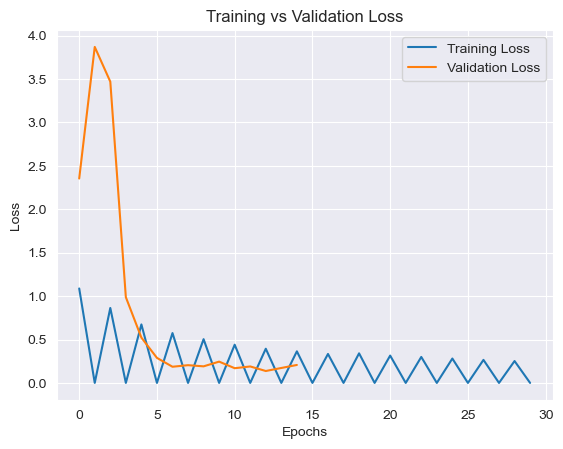

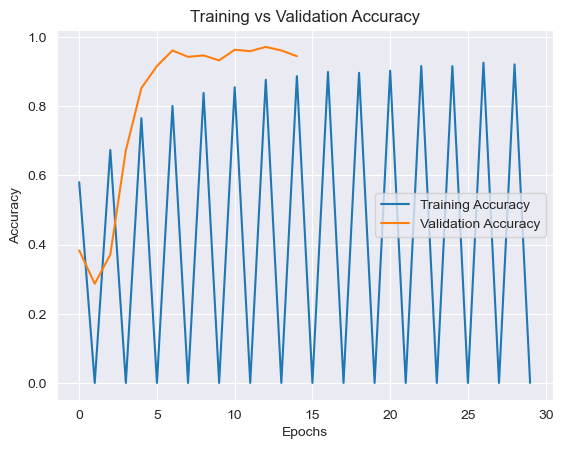

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

### Performance: Visualisasi Akurasi dan Loss per Epoch
1. **Tujuan**:
   - Visualisasi ini digunakan untuk menampilkan tren **training loss** dan **validation loss**, serta **training accuracy** dan **validation accuracy** selama proses pelatihan model. Hal ini membantu untuk menganalisis performa model per epoch.

2. **Penjelasan Kode**:
   - Dua subplot dibuat:
     - **Loss**: Menggambarkan perubahan nilai loss antara training dan validation data.
     - **Accuracy**: Menampilkan perubahan akurasi antara training dan validation data.
   - **`history.history`** berisi data akurasi dan loss per epoch yang diambil selama proses pelatihan.

3. **Output**:
   - Grafik pertama menunjukkan tren **Loss** per epoch.
   - Grafik kedua menunjukkan tren **Accuracy** per epoch.
   - Dengan visualisasi ini, kita dapat melihat apakah model mengalami overfitting atau underfitting serta evaluasi performa model selama pelatihan.

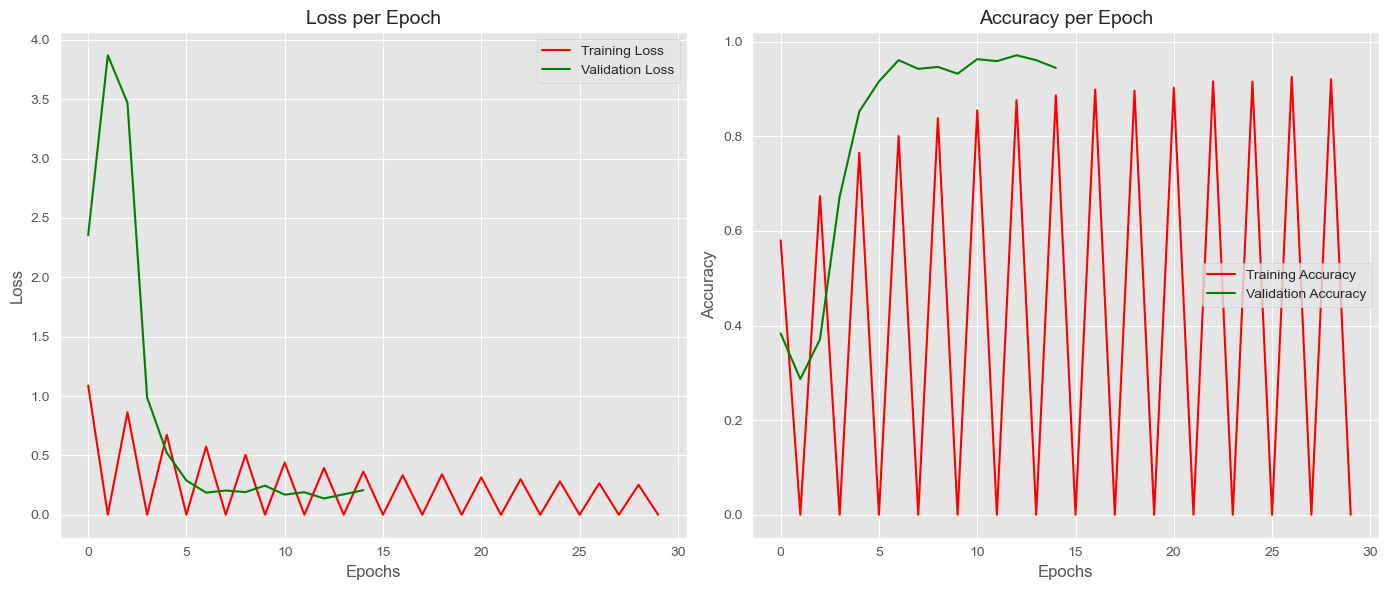

In [13]:
# Visualisasi Training & Validation Loss dan Accuracy
plt.figure(figsize=(14, 6))
plt.style.use('ggplot')

# Subplot untuk Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Loss per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

# Subplot untuk Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Accuracy per Epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()


### Performance: Visualisasi Pie Chart Proporsi dari Dataset
**Tujuan**:
   - Visualisasi ini digunakan untuk menampilkan proporsi dari masing-masing kelas dalam dataset **training** dan **validation**. Pie chart memberikan gambaran visual yang jelas mengenai distribusi jumlah gambar dalam setiap kelas.

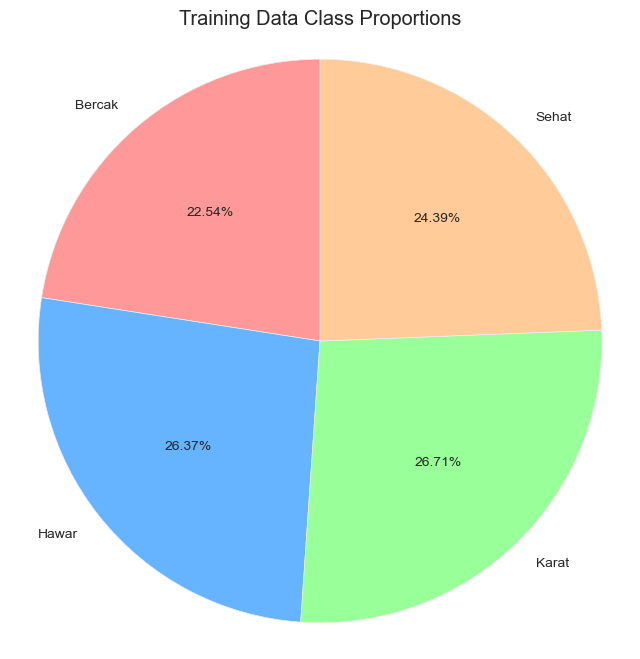

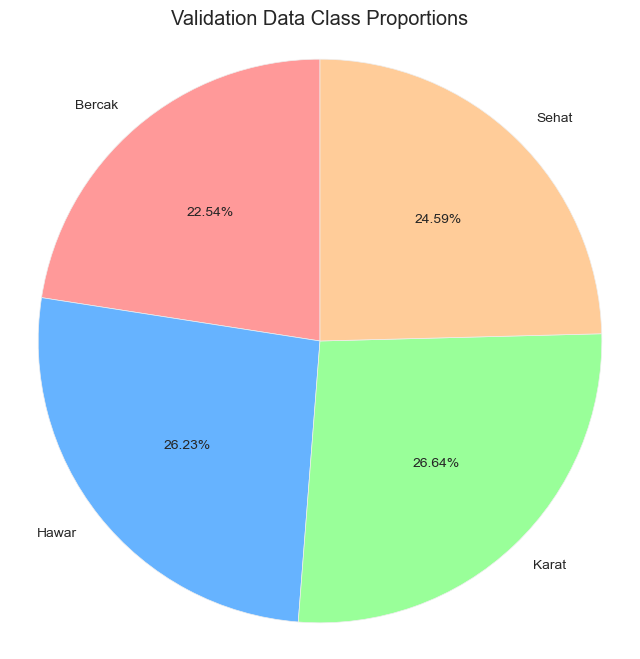

In [20]:
import matplotlib.pyplot as plt

# Data untuk proporsi kelas training
train_classes = ['Bercak', 'Hawar', 'Karat', 'Sehat']
train_proportions = [990, 1158, 1173, 1071]

# Data untuk proporsi kelas validation
val_classes = ['Bercak', 'Hawar', 'Karat', 'Sehat']
val_proportions = [110, 128, 130, 120]

# Fungsi untuk menampilkan pie chart
def plot_pie_chart(classes, proportions, title):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(proportions, labels=classes, autopct='%1.2f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    ax.axis('equal')  # Agar pie chart berbentuk lingkaran sempurna
    plt.title(title)
    plt.show()

# Visualisasi untuk Training data
plot_pie_chart(train_classes, train_proportions, "Training Data Class Proportions")

# Visualisasi untuk Validation data
plot_pie_chart(val_classes, val_proportions, "Validation Data Class Proportions")

#### Verifikasi Data Evaluasi

In [24]:
from tensorflow.keras.utils import to_categorical
y_val = to_categorical(y_val, num_classes=n_classes)


#### Verifikasi Prediksi Probabilitas

In [26]:
model.add(Dense(n_classes, activation='softmax'))


In [27]:
print("Sample Predictions (probabilities):", y_pred[:5])
print("Sample True Labels:", y_val[:5])


Sample Predictions (probabilities): [[9.9863464e-01 1.3417135e-03 2.3518191e-05 6.3039479e-08]
 [9.9751318e-01 2.2893436e-03 1.9635631e-04 1.1239827e-06]
 [9.9978572e-01 1.9825718e-04 1.5959236e-05 2.5637576e-08]
 [2.1357599e-04 3.6877380e-05 9.9974948e-01 7.6906979e-08]
 [4.1322568e-03 2.4958004e-03 9.9336219e-01 9.7102438e-06]]
Sample True Labels: [[[0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]]]


### Performance: ROC Curve dan AUC (Area Under Curve)
**Tujuan**:
   - Mengevaluasi performa model dengan menggunakan ROC Curve untuk setiap kelas. 
   - Memberikan pemahaman tentang keseimbangan **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**, dengan Area Under the Curve (AUC) sebagai metrik utama.

**Output**:
   - Grafik ROC Curve yang menunjukkan performa klasifikasi untuk setiap kelas.
   - Nilai AUC untuk masing-masing kelas ditampilkan pada legenda, memberikan gambaran tentang akurasi prediksi untuk setiap kelas.

#### Re-generate ROC Curve

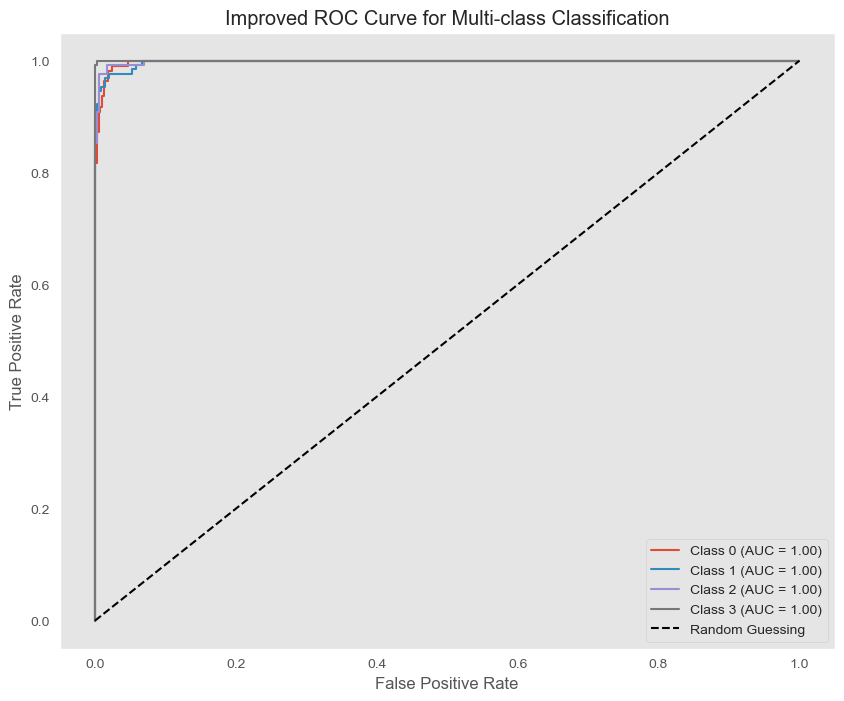

In [28]:
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('Improved ROC Curve for Multi-class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Performance: ROC Curve (Jika Menggunakan Output Probabilitas Multiclass)
**Tujuan**:
   - ROC Curve digunakan untuk mengevaluasi performa model klasifikasi pada setiap kelas dalam masalah multiclass. Area Under the Curve (AUC) memberikan indikasi seberapa baik model memisahkan kelas-kelas yang berbeda. ROC curve menunjukkan trade-off antara **True Positive Rate** (TPR) dan **False Positive Rate** (FPR).

**Output**:
   - ROC curve untuk setiap kelas pada klasifikasi multiclass.
   - AUC (Area Under the Curve) ditampilkan untuk setiap kelas dalam legenda.
   - ROC curve memberikan gambaran tentang seberapa baik model memisahkan kelas-kelas yang berbeda, dengan nilai AUC mendekati 1 menunjukkan performa yang sangat baik.

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step


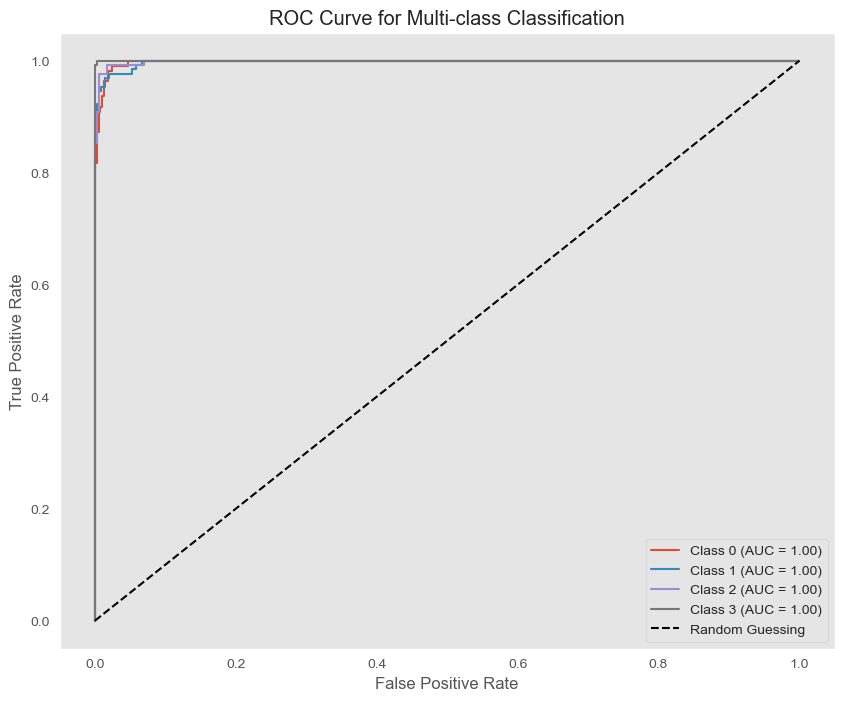

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Asumsi: valid_gen adalah generator untuk data validasi
# Ekstrak data validasi (fitur dan label)
x_val, y_val = zip(*(valid_gen[i] for i in range(len(valid_gen))))
x_val = np.concatenate(x_val)
y_val = np.concatenate(y_val)

# Prediksi probabilitas
y_pred = model.predict(x_val)

# Konversi label ke bentuk one-hot encoding jika belum
if y_val.ndim == 1 or y_val.shape[1] == 1:
    y_val = label_binarize(y_val, classes=[0, 1, 2, 3])  # Sesuaikan kelas

# ROC Curve dan AUC untuk setiap kelas
n_classes = y_val.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

# Hitung FPR, TPR, dan AUC untuk setiap kelas
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan diagonal garis random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.title('ROC Curve for Multi-class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Performance: Class Distribution
   - Memvisualisasikan distribusi data pada dataset training, validasi, dan uji.
   - Memastikan tidak ada ketidakseimbangan data yang signifikan antar kelas.

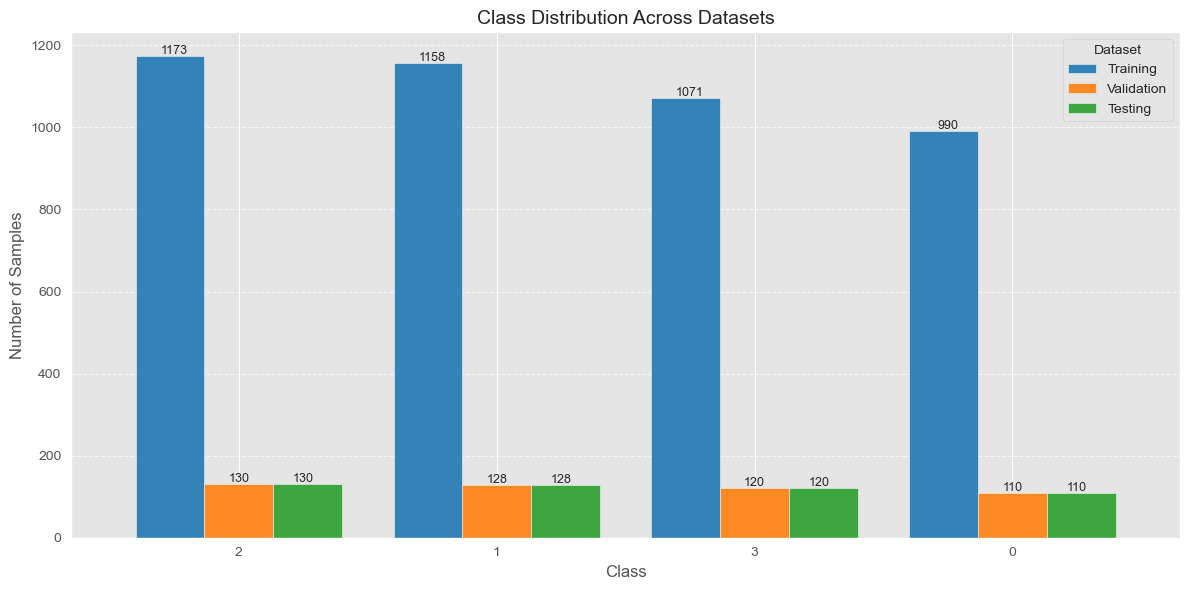

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data distribusi kelas
train_class_distribution = pd.Series(train_gen.classes).value_counts()
valid_class_distribution = pd.Series(valid_gen.classes).value_counts()
test_class_distribution = pd.Series(test_gen.classes).value_counts()

# Gabungkan semua distribusi menjadi satu DataFrame
df_distribution = pd.DataFrame({
    'Training': train_class_distribution,
    'Validation': valid_class_distribution,
    'Testing': test_class_distribution
}).fillna(0).astype(int)

# Plot distribusi kelas dengan Grouped Bar Chart
df_distribution.plot(
    kind='bar',
    figsize=(12, 6),
    width=0.8,
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Warna berbeda
    alpha=0.9
)

# Tambahkan informasi
plt.title('Class Distribution Across Datasets', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title='Dataset', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Tambahkan nilai di atas setiap batang
for i, col in enumerate(df_distribution.columns):
    for x, y in enumerate(df_distribution[col]):
        plt.text(x + (i - 1) * 0.25, y + 5, str(y), ha='center', fontsize=9)

plt.show()


<a name="Prediction"></a>

# Prediction 

### Prediction: Predict and Visualize a Single Image
melakukan prediksi terhadap satu gambar baru menggunakan model yang telah dilatih. Selain itu, hasil prediksi juga divisualisasikan bersama dengan label kelasnya.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Probabilitas untuk setiap kelas:
Bercak: 99.99%
Hawar: 0.00%
Karat: 0.00%
Sehat: 0.00%

Kelas yang diprediksi: Bercak (99.99%)


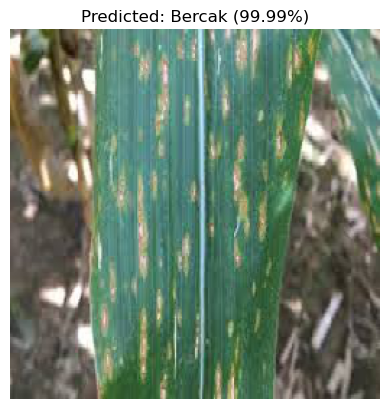

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Path model
MODEL_PATH = r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\CornLeaf-Disease-Identification-Using-Machine-Learning\Model\Model_CNN_256px.keras"

# Load model
model = load_model(MODEL_PATH)

def predict_image(model, img_path):
    # Load image dan ubah ukuran agar sesuai dengan input model
    img = image.load_img(img_path, target_size=(256, 256))

    # Mengubah gambar menjadi array
    img_array = image.img_to_array(img)

    # Menambahkan dimensi batch (batch_size = 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar
    img_array = img_array / 255.0

    # Prediksi
    prediction = model.predict(img_array)

    # Label kelas
    class_labels = {0: 'Bercak', 1: 'Hawar', 2: 'Karat', 3: 'Sehat'}

    # Menampilkan probabilitas untuk setiap kelas
    print("Probabilitas untuk setiap kelas:")
    probabilities = prediction[0] * 100
    for i, prob in enumerate(probabilities):
        print(f"{class_labels[i]}: {prob:.2f}%")

    # Prediksi akhir
    predicted_index = np.argmax(prediction)
    print(f"\nKelas yang diprediksi: {class_labels[predicted_index]} ({probabilities[predicted_index]:.2f}%)")

    return predicted_index, prediction

def predict_and_visualize_image(model, img_path):
    # Prediksi dan ambil probabilitas serta kelas
    predicted_index, prediction = predict_image(model, img_path)
    
    # Label kelas
    class_labels = {0: 'Bercak', 1: 'Hawar', 2: 'Karat', 3: 'Sehat'}
    
    # Load dan tampilkan gambar
    img = image.load_img(img_path, target_size=(256, 256))
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_index]} ({prediction[0][predicted_index]*100:.2f}%)")
    plt.axis('off')
    plt.show()

# Contoh Pemakaian dengan Visualisasi
img_path = 'Testing/test.jpg'  # Ganti dengan path gambar
predict_and_visualize_image(model, img_path)


<a name="ModelTransferLearningDenseNet"></a>

# Model Transfer Learning DenseNet121

### Imports dan Konfigurasi Dataset
Sel ini berisi library yang diperlukan dan setup dataset.

In [1]:
# Import library
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.image as mpimg                           # Library untuk memuat dan memanipulasi gambar

# Library Keras untuk membangun dan melatih model pembelajaran mendalam
from tensorflow.keras.models import Sequential, Model      # API untuk membuat model secara berurutan atau fungsional
from tensorflow.keras.optimizers import Adam               # Optimizer Adam untuk melatih model (optimisasi gradien)
from tensorflow.keras.callbacks import EarlyStopping       # Callback untuk menghentikan pelatihan dini jika performa memburuk
from tensorflow.keras.regularizers import l1, l2           # Regularisasi L1 dan L2 untuk mengurangi overfitting pada model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation dan preprocessing untuk gambar

# Berbagai jenis lapisan untuk membangun jaringan saraf tiruan
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization  

# Model pra-terlatih untuk transfer learning
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19


<a name="ModelTransferLearningDenseNet"></a>

# Data Preprocessing

### Mempersiapkan Data Latih (Train Data)

In [2]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'D:\\MATA KULIAH - DEL\\SEMESTER 5\\Pembelajaran Mesin\\Project Machine Learning\\Project Machine Learning\\Identification cornleaf diseases.v1i.folder\\train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)

train_data = train_data.map(lambda x, y: (x / 255.0, y))


Found 4392 files belonging to 4 classes.


### Mempersiapkan Data Validasi (Validation Data)

In [3]:
val_data = tf.keras.utils.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\valid',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)

val_data = val_data.map(lambda x, y: (x / 255.0, y))


Found 488 files belonging to 4 classes.


### Mempersiapkan Data Test (Test Data)

In [5]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\test',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

test_data = test_data.map(lambda x, y: (x / 255.0, y))

Found 488 files belonging to 4 classes.


<a name="ModelTransferLearningDenseNet"></a>

# Visualisasi Gambar

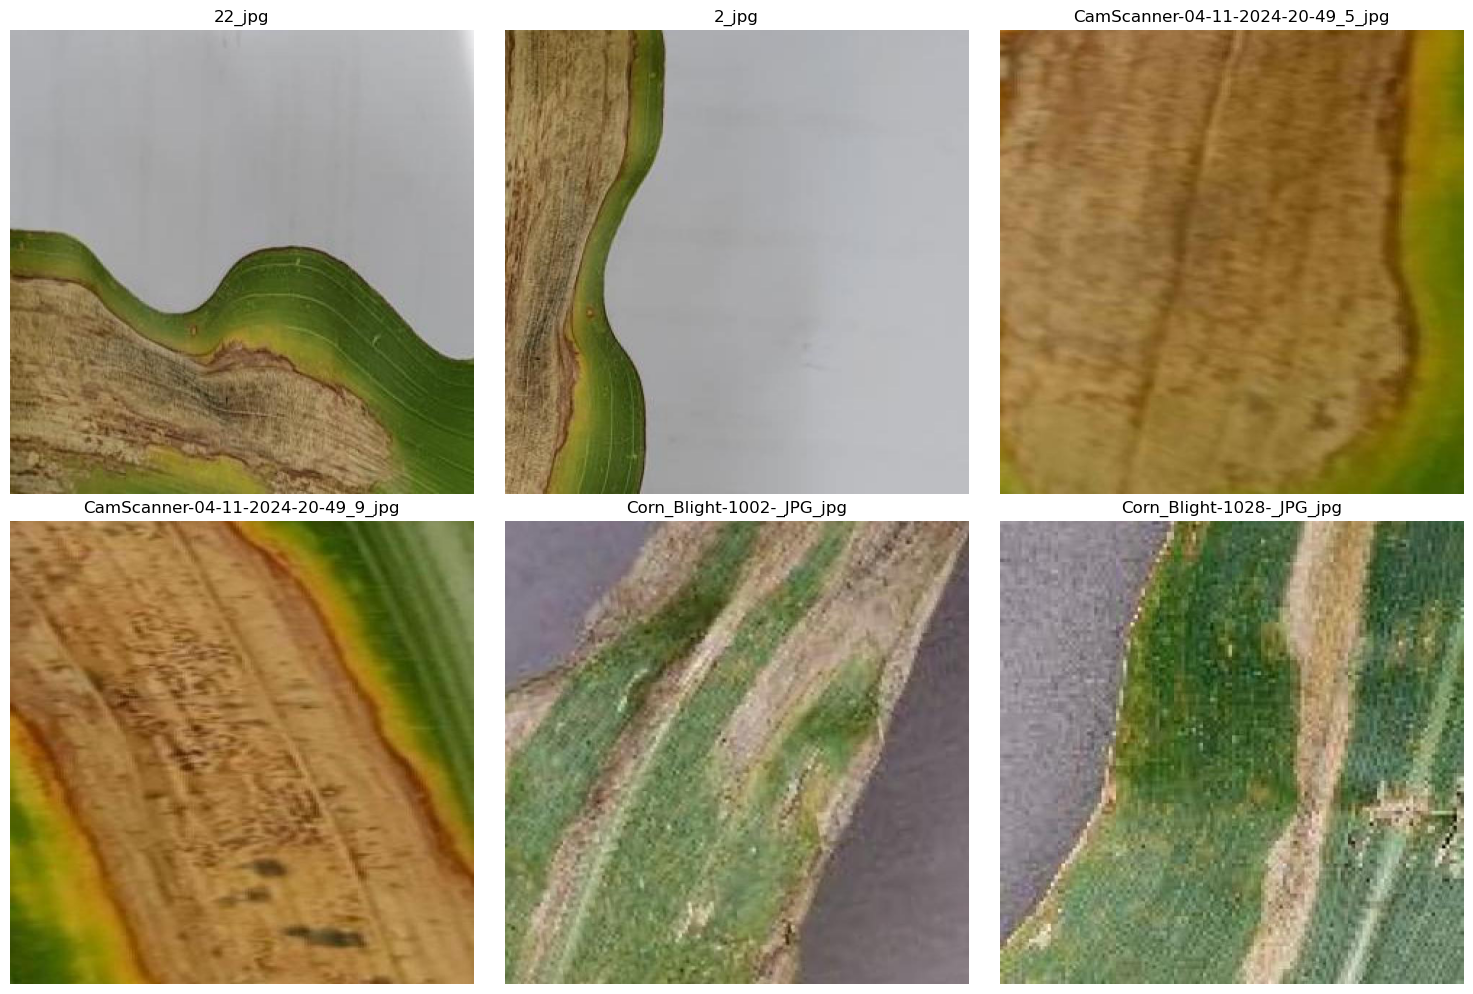

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path ke direktori yang berisi gambar
path = r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\Identification cornleaf diseases.v1i.folder\test\Hawar"

# Mendapatkan daftar nama file gambar di dalam direktori
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Menampilkan 6 gambar pertama beserta labelnya
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Mendapatkan nama file gambar dan labelnya (misalnya berdasarkan nama file)
    image_file = image_files[i]
    label = image_file.split('.')[0]  # Menggunakan nama file sebagai label

    # Membaca dan menampilkan gambar
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')  # Menyembunyikan sumbu
    ax.set_title(label)

plt.tight_layout()
plt.show()


<a name="ModelTransferLearningDenseNet"></a>

# Arsitektur Model DenseNet121

In [7]:
# Membuat basis model (convolutional base) menggunakan arsitektur DenseNet121 yang telah dilatih sebelumnya
conv_base = DenseNet121(
    weights='imagenet',            # Menggunakan bobot yang telah dilatih pada dataset ImageNet
    include_top=False,             # Tidak menyertakan lapisan fully connected (FC) terakhir dari DenseNet121
    input_shape=(256, 256, 3),     # Ukuran input gambar adalah 256x256 piksel dengan 3 saluran warna (RGB)
    pooling='avg'                  # Menambahkan lapisan pooling global rata-rata (average pooling)
)

In [8]:
# Membekukan bobot (weights) pada model basis agar tidak dilatih ulang
conv_base.trainable = False


# Baris ini menetapkan bahwa semua lapisan dalam model DenseNet121 (basis model) tidak akan dilatih ulang.
# Dengan kata lain, bobot (weights) dari model pra-terlatih yang telah diambil dari ImageNet tetap utuh dan tidak akan diperbarui selama proses pelatihan.

In [9]:
conv_base.summary()

# Header
# Model: "densenet121"
# Menunjukkan bahwa model yang digunakan adalah DenseNet121, salah satu arsitektur CNN (Convolutional Neural Network) populer.



# Kolom-Kolom
# Layer (type)
# Menampilkan nama dan jenis setiap lapisan (layer) dalam model. Contohnya:

# InputLayer: Lapisan input untuk menerima data dengan bentuk tertentu.
# Conv2D: Lapisan konvolusi 2D untuk ekstraksi fitur dari gambar.
# BatchNormalization: Lapisan untuk normalisasi output agar pelatihan lebih stabil.
# Activation: Lapisan aktivasi, seperti ReLU, untuk menambahkan non-linearitas.
# MaxPooling2D: Lapisan pooling untuk mengurangi dimensi fitur sambil mempertahankan informasi penting.



# Output Shape
# Menunjukkan bentuk (shape) output dari setiap lapisan.
# Contoh:

# (None, 256, 256, 3):
# None: Menunjukkan bahwa batch size fleksibel dan dapat berubah-ubah.
# 256, 256, 3: Menunjukkan ukuran gambar, yaitu 256x256 piksel dengan 3 saluran warna (RGB).
# (None, 128, 128, 64): Output dari lapisan konvolusi pertama, menghasilkan 64 feature maps dengan ukuran 128x128 piksel.



# Param # (Jumlah Parameter) 
# Jumlah bobot (weights) dan bias yang dapat dilatih untuk setiap lapisan: 
# Contoh pada Conv2D: 9,408 parameter dihitung sebagai: (ukuran kernel × ukuran kernel × jumlah saluran input × jumlah filter) + jumlah filter
# Dalam kasus ini, kernel memiliki ukuran 3x3, jumlah saluran input adalah 3 (RGB), dan jumlah filter adalah 64:
# (3×3×3×64)+64=9,408.



# Connected to
# Menunjukkan lapisan sebelumnya yang terhubung ke lapisan saat ini. Contohnya:

# zero_padding2d_1 terhubung ke conv1_relu, artinya lapisan ZeroPadding2D menerima input dari lapisan Activation sebelumnya.




# Penjelasan Per Lapisan:
# input_layer (InputLayer)
# Lapisan pertama menerima input dengan ukuran (256, 256, 3). Ini sesuai dengan gambar berwarna (RGB) yang diubah ukurannya menjadi 256x256 piksel.

# zero_padding2d (ZeroPadding2D)
# Menambahkan padding pada gambar sehingga ukurannya meningkat menjadi (262, 262, 3). Padding berguna untuk menjaga ukuran gambar saat melewati lapisan konvolusi.

# conv1_conv (Conv2D)
# Lapisan konvolusi pertama menghasilkan 64 feature maps dengan ukuran (128, 128) menggunakan filter 3x3.

# conv1_bn (BatchNormalization)
# Normalisasi output dari lapisan konvolusi untuk mempercepat pelatihan dan stabilitas.

# conv1_relu (Activation)
# Menambahkan fungsi aktivasi ReLU untuk menghasilkan nilai non-linear dari output sebelumnya.

# pool1 (MaxPooling2D)
# Mengurangi dimensi fitur dari (130, 130, 64) menjadi (64, 64, 64) dengan memilih nilai maksimum dalam jendela pooling.

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

<a name="Performance"></a>

# Membangun Model dengan DenseNet

In [10]:
# Membuat model sequential yang berarti model ini terdiri dari urutan lapisan (layers)
model = Sequential()

# Menambahkan lapisan konvolusional dasar yang sudah dilatih sebelumnya (conv_base), seperti DenseNet121
# Lapisan ini sudah memproses gambar dan menghasilkan fitur yang siap digunakan untuk klasifikasi
model.add(conv_base)

# Menambahkan Batch Normalization setelah lapisan konvolusional untuk menormalkan data
# Batch Normalization membantu dalam mempercepat pelatihan dan meningkatkan stabilitas model
model.add(BatchNormalization())

# Menambahkan lapisan Dense (fully connected) dengan 256 neuron dan aktivasi ReLU
# ReLU digunakan untuk memperkenalkan non-linearitas dalam model, membantu model belajar representasi yang lebih kompleks
model.add(Dense(256, activation='relu'))

# Menambahkan Dropout untuk regularisasi, di mana 35% neuron akan "dibuang" selama pelatihan
# Dropout membantu menghindari overfitting dengan memaksa model untuk tidak terlalu bergantung pada neuron tertentu
model.add(Dropout(0.35))

# Menambahkan Batch Normalization lagi setelah Dropout untuk menormalkan data
# Ini untuk memastikan bahwa data yang masuk ke lapisan selanjutnya memiliki distribusi yang stabil
model.add(BatchNormalization())

# Menambahkan lapisan Dense dengan 120 neuron dan aktivasi ReLU
# Ini lapisan tersembunyi yang lebih kecil setelah lapisan yang lebih besar di atasnya
model.add(Dense(120, activation='relu'))

# Menambahkan lapisan output dengan 4 neuron dan aktivasi softmax untuk klasifikasi multi-kelas
# Softmax memastikan output dapat diperlakukan sebagai probabilitas untuk masing-masing kelas
# Di sini, kita menyesuaikan model untuk klasifikasi dengan 4 kelas
model.add(Dense(4, activation='softmax'))  # Ubah jumlah kelas menjadi 4


<a name="Prediction"></a>

# Menyusun dan Melatih Model

In [ ]:
# Mengimpor TensorFlow dan ModelCheckpoint untuk menyimpan model terbaik selama pelatihan
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Membuat kelas callback kustom untuk menghentikan pelatihan jika akurasi validasi lebih dari 98%
class myCallback(tf.keras.callbacks.Callback):
    # Fungsi yang dipanggil pada akhir setiap epoch
    def on_epoch_end(self, epoch, logs=None):
        # Memeriksa apakah akurasi validasi lebih dari 98%
        if logs.get('val_accuracy') > 0.98:
            print("\nReached 98% accuracy so cancelling training!")  # Menampilkan pesan
            self.model.stop_training = True  # Menghentikan pelatihan

# Membuat objek callback kustom
callbacks = myCallback()

# Menyiapkan checkpoint untuk menyimpan model terbaik berdasarkan akurasi validasi
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Menyimpan model ke file 'best_model.keras'
    monitor='val_accuracy',      # Memantau akurasi validasi
    save_best_only=True,         # Hanya menyimpan model dengan akurasi validasi terbaik
    mode='max',                  # Memilih mode 'max' untuk memaksimalkan akurasi
    verbose=1                    # Menampilkan pesan saat model disimpan
)

# Menyusun model dengan optimizer Adamax dan loss function categorical crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),  # Menggunakan optimizer Adamax dengan learning rate 0.001
    loss='categorical_crossentropy',  # Menggunakan categorical crossentropy sebagai loss function untuk klasifikasi multi-kelas
    metrics=['accuracy']  # Memantau akurasi selama pelatihan
)

# Melatih model dengan data pelatihan dan data validasi
history = model.fit(
    train_data,  # Data pelatihan
    epochs=5,    # Melakukan pelatihan selama 5 epoch
    batch_size=32,  # Ukuran batch untuk pelatihan
    verbose=1,  # Menampilkan kemajuan pelatihan setiap epoch
    validation_data=val_data,  # Data validasi untuk mengevaluasi model setelah setiap epoch
    callbacks=[callbacks, checkpoint]  # Menggunakan callbacks untuk menghentikan pelatihan dan menyimpan model terbaik
)


<a name="Prediction"></a>

### Accuration

In [11]:
from tensorflow.keras.models import load_model

# Path model
MODEL_PATH = r"D:\MATA KULIAH - DEL\SEMESTER 5\Pembelajaran Mesin\Project Machine Learning\Project Machine Learning\CornLeaf-Disease-Identification-Using-Machine-Learning\best_model.keras"

# Load model
model = load_model(MODEL_PATH)

# Load model yang sudah disimpan
model = load_model("best_model.keras")

In [12]:
# Mengevaluasi model menggunakan data validasi
evaluation = model.evaluate(val_data)  # Fungsi evaluate mengembalikan loss dan akurasi pada data validasi

# Mencetak metrik hasil evaluasi
print("Validation Loss:", evaluation[0])  # Menampilkan nilai loss pada data validasi
print("Validation Accuracy:", evaluation[1])  # Menampilkan nilai akurasi pada data validasi

16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9742 - loss: 0.0684
Validation Loss: 0.07214024662971497
Validation Accuracy: 0.9774590134620667


<a name="Prediction"></a>

# Evaluasi Model pada Data Validasi dan Test

In [ ]:
# Evaluasi pada data validasi
val_score = model.evaluate(val_data)
print(f"Validation Loss: {val_score[0]}")
print(f"Validation Accuracy: {val_score[1]}")

# Evaluasi pada data test
test_score = model.evaluate(test_data)
print(f"Test Loss: {test_score[0]}")
print(f"Test Accuracy: {test_score[1]}")


<a name="Prediction"></a>

In [13]:
# Mengambil data akurasi dan loss dari hasil pelatihan (training) dan validasi
tr_acc = history.history['accuracy']  # Akurasi pelatihan
tr_loss = history.history['loss']     # Loss pelatihan
val_acc = history.history['val_accuracy']  # Akurasi validasi
val_loss = history.history['val_loss']     # Loss validasi

# Menentukan epoch dengan loss validasi terendah
index_loss = np.argmin(val_loss)  # Menemukan index dari loss validasi terendah
val_lowest = val_loss[index_loss]  # Nilai loss validasi terendah

# Menentukan epoch dengan akurasi validasi tertinggi
index_acc = np.argmax(val_acc)  # Menemukan index dari akurasi validasi tertinggi
acc_highest = val_acc[index_acc]  # Nilai akurasi validasi tertinggi

# Membuat list yang berisi nomor epoch
Epochs = [i+1 for i in range(len(tr_acc))]  # Membuat list epoch dimulai dari 1

# Menyiapkan label untuk titik terbaik pada plot
loss_label = f'best epoch= {str(index_loss + 1)}'  # Label untuk epoch dengan loss terbaik
acc_label = f'best epoch= {str(index_acc + 1)}'  # Label untuk epoch dengan akurasi terbaik

# Menyiapkan figure untuk menampilkan plot
plt.figure(figsize= (20, 8))  # Ukuran gambar plot
plt.style.use('fivethirtyeight')  # Menggunakan style fivethirtyeight untuk plot

# Membuat plot untuk loss pelatihan dan validasi
plt.subplot(1, 2, 1)  # Membuat subplot pertama untuk loss
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')  # Plot loss pelatihan (merah)
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')  # Plot loss validasi (hijau)
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)  # Titik terbaik untuk loss (biru)
plt.title('Training and Validation Loss')  # Judul plot untuk loss
plt.xlabel('Epochs')  # Label untuk sumbu x (epoch)
plt.ylabel('Loss')  # Label untuk sumbu y (loss)
plt.legend()  # Menampilkan legenda untuk plot

# Membuat plot untuk akurasi pelatihan dan validasi
plt.subplot(1, 2, 2)  # Membuat subplot kedua untuk akurasi
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')  # Plot akurasi pelatihan (merah)
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')  # Plot akurasi validasi (hijau)
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)  # Titik terbaik untuk akurasi (biru)
plt.title('Training and Validation Accuracy')  # Judul plot untuk akurasi
plt.xlabel('Epochs')  # Label untuk sumbu x (epoch)
plt.ylabel('Accuracy')  # Label untuk sumbu y (akurasi)
plt.legend()  # Menampilkan legenda untuk plot

# Menata layout plot agar lebih rapat
plt.tight_layout()  # Menata layout agar tidak ada yang tumpang tindih

# Menampilkan plot
plt.show()  # Menampilkan plot yang telah dibuat


NameError: name 'history' is not defined

In [14]:
def model_evaluation(model):
    # Menghitung evaluasi model pada data pelatihan (train_data)
    train_score = model.evaluate(train_data, verbose=1)  # Evaluasi pada data pelatihan
    # Menghitung evaluasi model pada data validasi (val_data)
    valid_score = model.evaluate(val_data, verbose=1)  # Evaluasi pada data validasi
    # Menghitung evaluasi model pada data pengujian (test_data)
    test_score = model.evaluate(test_data, verbose=1)  # Evaluasi pada data pengujian
    
    # Menampilkan hasil evaluasi untuk data pelatihan
    print("Train Loss: ", train_score[0])  # Menampilkan nilai loss untuk data pelatihan
    print("Train Accuracy: ", train_score[1])  # Menampilkan nilai akurasi untuk data pelatihan
    print('-' * 20)  # Menampilkan garis pemisah agar hasil lebih rapi
    
    # Menampilkan hasil evaluasi untuk data validasi
    print("Validation Loss: ", valid_score[0])  # Menampilkan nilai loss untuk data validasi
    print("Validation Accuracy: ", valid_score[1])  # Menampilkan nilai akurasi untuk data validasi
    print('-' * 20)  # Menampilkan garis pemisah
    
    # Menampilkan hasil evaluasi untuk data pengujian
    print("Test Loss: ", test_score[0])  # Menampilkan nilai loss untuk data pengujian
    print("Test Accuracy: ", test_score[1])  # Menampilkan nilai akurasi untuk data pengujian


In [15]:
def get_pred(model, test_data):
    # Menggunakan model untuk memprediksi data uji (test_data)
    preds = model.predict(test_data)  # Model membuat prediksi berdasarkan data uji
    
    # Mengambil kelas dengan probabilitas tertinggi dari hasil prediksi (outputnya adalah probabilitas)
    y_pred = np.argmax(preds, axis=1)  # Mengambil indeks kelas dengan probabilitas tertinggi untuk setiap sampel
    
    # Mengembalikan hasil prediksi berupa kelas (bukan probabilitas)
    return y_pred


Found 488 images belonging to 4 classes.


c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step


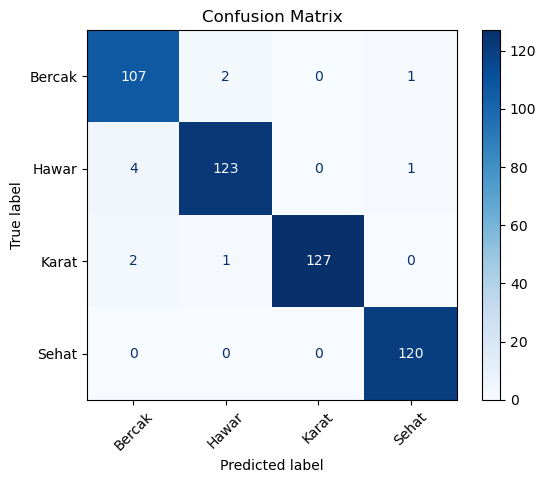

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator untuk melakukan pra-pemrosesan gambar (misalnya normalisasi piksel)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Menormalisasi nilai piksel gambar antara 0 dan 1

# Menggunakan flow_from_directory untuk memuat data uji dari folder
test_data = test_datagen.flow_from_directory(
    directory='D:\\MATA KULIAH - DEL\\SEMESTER 5\\Pembelajaran Mesin\\Project Machine Learning\\Project Machine Learning\\Identification cornleaf diseases.v1i.folder\\test',
    target_size=(256, 256),  # Menyesuaikan ukuran gambar menjadi 256x256 piksel
    batch_size=32,  # Ukuran batch adalah 32 gambar per iterasi
    class_mode='categorical',  # Menyediakan label kategori (untuk klasifikasi multi-kelas)
    shuffle=False  # Jangan mengacak urutan data (penting agar prediksi dapat dibandingkan dengan label yang benar)
)

# Menggunakan model untuk memprediksi kelas dari data uji
y_pred_probs = model.predict(test_data, verbose=1)  # Prediksi probabilitas kelas
y_pred = np.argmax(y_pred_probs, axis=1)  # Mengambil kelas dengan probabilitas tertinggi (indeks kelas)

# Label asli dari data uji
y_true = test_data.classes  # Mengambil label asli dari data uji yang telah disiapkan sebelumnya

# Mendapatkan nama-nama kelas dari direktori (sesuai dengan urutan yang ada di folder)
class_names = list(test_data.class_indices.keys())

# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_pred)  # Membuat confusion matrix dari label asli dan prediksi
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Menyiapkan tampilan confusion matrix
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # Plot confusion matrix dengan warna biru dan rotasi label pada sumbu X
    plt.title('Confusion Matrix')  # Menambahkan judul pada plot
    plt.show()  # Menampilkan plot

# Memanggil fungsi untuk menampilkan confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)


In [17]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix

# Menghitung metrik evaluasi berdasarkan prediksi dan label asli
accuracy = accuracy_score(y_true, y_pred)  # Menghitung akurasi model (proporsi prediksi yang benar)
recall = recall_score(y_true, y_pred, average='macro')  # Menghitung recall (sensitivitas) untuk semua kelas, rata-rata dengan metode 'macro'
f1 = f1_score(y_true, y_pred, average='macro')  # Menghitung F1 Score untuk semua kelas, rata-rata dengan metode 'macro'
precision = precision_score(y_true, y_pred, average='macro')  # Menghitung precision (presisi) untuk semua kelas, rata-rata dengan metode 'macro'
cm = confusion_matrix(y_true, y_pred)  # Membuat confusion matrix untuk menganalisis prediksi model

# Perhitungan Specificity (Spesifisitas) untuk setiap kelas
tn = cm.diagonal()  # True Negatives (nilai diagonal dari confusion matrix)
fp = cm.sum(axis=0) - tn  # False Positives (jumlah per kolom dikurangi nilai diagonal)
specificity = tn / (tn + fp)  # Specificity dihitung untuk setiap kelas

# Menampilkan hasil metrik
print(f"Accuracy: {accuracy:.4f}")  # Menampilkan akurasi dengan format 4 digit desimal
print(f"Recall: {recall:.4f}")  # Menampilkan recall dengan format 4 digit desimal
print(f"F1 Score: {f1:.4f}")  # Menampilkan F1 Score dengan format 4 digit desimal
print(f"Precision: {precision:.4f}")  # Menampilkan precision dengan format 4 digit desimal

Accuracy: 0.9775
Recall: 0.9776
F1 Score: 0.9771
Precision: 0.9767


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Bercak: 99.77%
Hawar: 0.09%
Karat: 0.13%
Sehat: 0.00%

Hasil Prediksi: Bercak (99.77%)


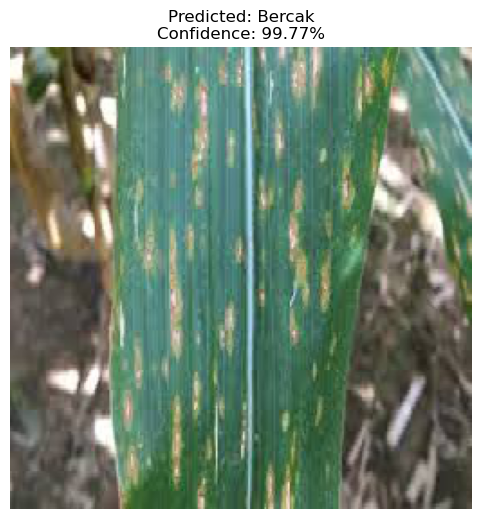

In [20]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Path ke gambar lokal
image_path = 'Testing/test.jpg'

# Load dan preprocess gambar (ubah ukuran gambar menjadi 256x256 sesuai dengan input model)
img = load_img(image_path, target_size=(256, 256))  # Sesuaikan ukuran menjadi 256x256
img_array = img_to_array(img) / 255.0  # Normalisasi (0-1), agar nilai piksel gambar berada dalam rentang 0 hingga 1
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension, agar input cocok dengan bentuk yang dibutuhkan model (batch_size, height, width, channels)

# Prediksi gambar
predictions = model.predict(img_array)  # Model akan memprediksi kelas gambar yang telah diproses

# Konversi probabilitas ke persentase
predicted_percentages = predictions[0] * 100  # Mengubah nilai probabilitas dari model menjadi persentase

# Definisikan kelas secara manual (sesuaikan dengan kelas yang Anda miliki)
class_labels = ['Bercak', 'Hawar', 'Karat', 'Sehat']  # Gantilah dengan nama kelas yang sesuai dengan dataset Anda

# Menampilkan hasil prediksi
for i, label in enumerate(class_labels):
    print(f"{label}: {predicted_percentages[i]:.2f}%")  # Menampilkan persentase prediksi untuk setiap kelas

# Menampilkan kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions, axis=1)  # Mengambil indeks kelas dengan probabilitas tertinggi
predicted_label = class_labels[predicted_class[0]]
confidence = predicted_percentages[predicted_class[0]]

print(f"\nHasil Prediksi: {predicted_label} ({confidence:.2f}%)")  # Menampilkan kelas yang diprediksi dan persentase kepercayaan model

# Visualisasi gambar dengan hasil prediksi
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.axis("off")
plt.show()


## #

<a name="Prediction"></a>

# Konversi Model .keras ke TensorFlow.js

In [1]:
pip install tensorflowjs

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow import keras
import json
import os

def convert_keras_to_tfjs_fixed(keras_model_path, output_dir):
    """
    Konversi Keras ke TensorFlow.js dengan fix untuk error optimizer
    """
    try:
        print("Loading Keras model...")
        model = keras.models.load_model(keras_model_path)
        print("Model loaded successfully!")
        
        # Tampilkan informasi model
        print("\nModel summary:")
        model.summary()
        
        # METHOD 1: Buat model baru tanpa optimizer state
        print("\nMethod 1: Creating new model without optimizer...")
        
        # Buat model baru dengan arsitektur yang sama
        new_model = keras.models.clone_model(model)
        new_model.set_weights(model.get_weights())
        
        # Compile ulang dengan optimizer sederhana
        new_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Simpan sebagai .h5 terlebih dahulu
        temp_h5_path = os.path.join(output_dir, "temp_model.h5")
        print(f"Saving temporary H5 model to: {temp_h5_path}")
        new_model.save(temp_h5_path, save_format='h5')
        
        # Buat direktori sementara untuk SavedModel
        temp_savedmodel_dir = os.path.join(output_dir, "temp_savedmodel")
        os.makedirs(temp_savedmodel_dir, exist_ok=True)
        
        print(f"Saving as SavedModel to: {temp_savedmodel_dir}")
        # Simpan SavedModel tanpa optimizer
        tf.saved_model.save(new_model, temp_savedmodel_dir, options=tf.saved_model.SaveOptions(save_debug_info=False))
        
        print("SavedModel saved successfully!")
        
        # METHOD 2: Langsung convert menggunakan tensorflowjs
        print("\nMethod 2: Direct conversion using tensorflowjs...")
        try:
            import tensorflowjs as tfjs
            tfjs_output_dir = os.path.join(output_dir, "tfjs_model")
            tfjs.converters.save_keras_model(new_model, tfjs_output_dir)
            print(f"✅ TensorFlow.js model saved to: {tfjs_output_dir}")
            return tfjs_output_dir
        except Exception as e:
            print(f"Direct conversion failed: {e}")
            print("Using SavedModel method instead...")
        
        print("\nUse command line for conversion:")
        print(f"tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model \"{temp_savedmodel_dir}\" \"{os.path.join(output_dir, 'tfjs_model')}\"")
        
        # Simpan informasi model untuk referensi
        model_info = {
            'input_shape': list(new_model.input_shape),
            'output_shape': list(new_model.output_shape),
            'num_classes': new_model.output_shape[-1] if new_model.output_shape else None,
            'model_type': 'sequential' if isinstance(new_model, keras.Sequential) else 'functional',
            'total_params': new_model.count_params(),
            'class_names': ['Blight', 'Common Rust', 'Gray Leaf Spot', 'Healthy']  # Sesuaikan dengan kelas Anda
        }
        
        with open(os.path.join(output_dir, 'model_info.json'), 'w') as f:
            json.dump(model_info, f, indent=2)
            
        print(f"\nModel info saved to: {os.path.join(output_dir, 'model_info.json')}")
        
        return temp_savedmodel_dir
        
    except Exception as e:
        print(f"Error in main conversion: {e}")
        
        # METHOD 3: Export weights only
        print("\nMethod 3: Trying weights-only approach...")
        try:
            weights = model.get_weights()
            config = model.get_config()
            
            # Recreate model from config
            clean_model = keras.models.Sequential.from_config(config)
            clean_model.set_weights(weights)
            clean_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            
            # Try direct TFJS conversion
            import tensorflowjs as tfjs
            tfjs_output_dir = os.path.join(output_dir, "tfjs_model")
            tfjs.converters.save_keras_model(clean_model, tfjs_output_dir)
            print(f"✅ Method 3 successful! Model saved to: {tfjs_output_dir}")
            return tfjs_output_dir
            
        except Exception as e3:
            print(f"Method 3 also failed: {e3}")
            return None

# Konfigurasi path
keras_model_path = r"D:\PROJECT\DBS DICODING\Capstone\JagungSehat\Model\Model_CNN_256px.keras"
output_dir = r"D:\PROJECT\DBS DICODING\Capstone\JagungSehat\Model"

# Jalankan konversi
result_path = convert_keras_to_tfjs_fixed(keras_model_path, output_dir)

if result_path:
    print("\n" + "="*60)
    print("🎉 KONVERSI BERHASIL!")
    print("="*60)
    if "tfjs_model" in result_path:
        print("✅ Model TensorFlow.js siap digunakan!")
        print(f"📁 Lokasi: {result_path}")
        print("\n📋 LANGKAH SELANJUTNYA:")
        print("1. Copy folder 'tfjs_model' ke folder 'public' di project React")
        print("2. Gunakan komponen React yang sudah disediakan")
        print("3. Pastikan class names sesuai dengan model Anda")
    else:
        print("⚠️ Gunakan command line converter:")
        print(f"tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model \"{result_path}\" \"{os.path.join(output_dir, 'tfjs_model')}\"")
    print("="*60)
else:
    print("\n❌ Konversi gagal. Coba alternatif berikut:")
    print("1. Gunakan Google Colab")
    print("2. Atau gunakan command line converter langsung")
    print("3. Atau coba script command line converter di bawah")

Loading Keras model...
Model loaded successfully!

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,762,382 (6.72 MB)

 Trainable params: 587,140 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,174,282 (4.48 MB)


Method 1: Creating new model without optimizer...


Saving temporary H5 model to: D:\PROJECT\DBS DICODING\Capstone\JagungSehat\Model\temp_model.h5
Saving as SavedModel to: D:\PROJECT\DBS DICODING\Capstone\JagungSehat\Model\temp_savedmodel
Error in main conversion: this __dict__ descriptor does not support '_DictWrapper' objects

Method 3: Trying weights-only approach...
Method 3 also failed: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

❌ Konversi gagal. Coba alternatif berikut:
1. Gunakan Google Colab
2. Atau gunakan command line converter langsung
3. Atau coba script command line converter di bawah


c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]
